In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
#plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
import uproot

In [2]:
##### function definitions
# different definitions of hadronic energy
def cal_Ehadtrue(pdg, E, m):
    Ehadtrue = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 2112]:
            Ehadtrue += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadtrue += E[ip]
    return Ehadtrue
def cal_Ehadreco(pdg, E, m):
    Ehadreco = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212]:
            Ehadreco += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadreco += E[ip]
    return Ehadreco
def cal_Eavail(pdg, E, m):
    Eavail = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 211, -211]:
            Eavail += (E[ip] - m[ip])
        elif pdg[ip] in [111, 22, 321, -321, 311]:
            Eavail += E[ip]
    return Eavail
def get_Ehad_array(vars_dict, cal_Ehad_func):
    nevts = len(vars_dict["Ev"])
    pdgi = vars_dict["pdgi"]
    Ei = vars_dict["Ei"]
    mi = []
    Eavail_i = []
    pdgf = vars_dict["pdgf"]
    Ef = vars_dict["Ef"]
    mf = []
    Eavail_f = []
    
    for ievt in range(nevts):
        pisq = vars_dict["pxi"][ievt]*vars_dict["pxi"][ievt] + vars_dict["pyi"][ievt]*vars_dict["pyi"][ievt] + vars_dict["pzi"][ievt]*vars_dict["pzi"][ievt]
        mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
        Eavail_i.append(cal_Ehad_func(pdgi[ievt], Ei[ievt], mi[ievt]))
        
        mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
        Eavail_f.append(cal_Ehad_func(pdgf[ievt], Ef[ievt], mf[ievt]))
        
    return np.array(Eavail_i), np.array(Eavail_f)

# neutrino energy bias
def get_Ebias(vars_dict, cal_Ehad_func):
    Ehadi, Ehadf = get_Ehad_array(vars_dict, cal_Ehad_func)
    return vars_dict["El"] + Ehadi - vars_dict["Ev"], vars_dict["El"] + Ehadf - vars_dict["Ev"]
def get_relative_Ebias(vars_dict, cal_Ehad_func):
    Ebiasi, Ebiasf = get_Ebias(vars_dict, cal_Ehad_func)
    return Ebiasi / vars_dict["Ev"], Ebiasf / vars_dict["Ev"]

# other useful
def safe_divide(numerator, denominator, default_value=100):
    # 0/0 = 1, 0/x = 0, x/0 = default_value
    result = np.ones_like(numerator, dtype=float)  # Default result is 1
    mask_both_zero = (numerator == 0) & (denominator == 0)
    mask_only_denominator_zero = (denominator == 0) & ~mask_both_zero

    result[~mask_both_zero & ~mask_only_denominator_zero] = numerator[~mask_both_zero & ~mask_only_denominator_zero] / denominator[~mask_both_zero & ~mask_only_denominator_zero]
    result[mask_only_denominator_zero] = default_value  # Assign default value where denominator is zero and numerator is non-zero
    return np.nan_to_num(result, nan=default_value)  # Replace NaN with default_value

def fill_between_gradient(ax, x, y, y_upp, y_low,
                          alpha=0.3, resolution=1000, zorder=0,
                          cmap=None, label=None):
    """
    Draw a vertical red-white-blue gradient between y_upp and y_low on the given axes.
    White is centered at y(x), red at y_upp, and blue at y_low.

    Parameters:
    - ax: matplotlib Axes object
    - x: 1D array of x-coordinates
    - y: 1D array for the white center line
    - y_upp: 1D array for the red-side boundary
    - y_low: 1D array for the blue-side boundary
    - alpha: float (0 to 1), maximum opacity of the fill
    - resolution: int, resolution for the rendered gradient image
    - zorder: drawing layer
    - cmap: optional colormap (default is red-white-blue)
    - label: optional label (not used in legend but allows consistent API)
    """
    import numpy as np
    from scipy.interpolate import interp1d
    from matplotlib.colors import LinearSegmentedColormap

    if cmap is None:
        cmap = LinearSegmentedColormap.from_list("rwb", ["blue", "white", "red"])

    # Ensure input as arrays
    x = np.asarray(x)
    y = np.asarray(y)
    y_upp = np.asarray(y_upp)
    y_low = np.asarray(y_low)

    dy = (y_upp - y_low) / 2

    # Create meshgrid for plotting
    nx, ny = resolution, resolution
    X = np.linspace(x.min(), x.max(), nx)
    Y = np.linspace(min(y_upp.min(), y_low.min()) - 0.2,
                    max(y_upp.max(), y_low.max()) + 0.2, ny)
    XX, YY = np.meshgrid(X, Y)

    # Interpolate center and width to the mesh x values
    center_func = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
    dy_func = interp1d(x, dy, bounds_error=False, fill_value="extrapolate")
    y0 = center_func(X)
    dy_vals = dy_func(X)

    # Interpolate upper/lower bounds *before* evaluating the mask
    y_upp_interp = interp1d(x, y_upp, bounds_error=False, fill_value="extrapolate")(X)
    y_low_interp = interp1d(x, y_low, bounds_error=False, fill_value="extrapolate")(X)
    y_top = np.maximum(y_upp_interp, y_low_interp)
    y_bot = np.minimum(y_upp_interp, y_low_interp)

    # Safe division to normalize gradient [-1, 1]
    def safe_divide(numerator, denominator, default_value=100):
        numerator, denominator = np.broadcast_arrays(numerator, denominator)
        result = np.ones_like(numerator)
        mask_both_zero = (numerator == 0) & (denominator == 0)
        mask_only_zero = (denominator == 0) & ~mask_both_zero
        mask_valid = ~mask_both_zero & ~mask_only_zero
        result[mask_valid] = numerator[mask_valid] / denominator[mask_valid]
        result[mask_only_zero] = default_value
        return np.nan_to_num(result, nan=default_value)

    norm_val = safe_divide(YY - y0, dy_vals)
    norm_val = np.clip(norm_val, -1, 1)

    # Alpha mask: only show pixels between the two bounds
    alpha_mask = ((YY >= y_bot) & (YY <= y_top)).astype(float) * alpha

    # Draw the image
    ax.imshow(norm_val,
              extent=[X.min(), X.max(), Y.min(), Y.max()],
              origin='lower',
              aspect='auto',
              cmap=cmap,
              alpha=alpha_mask,
              zorder=zorder,
              label=label)


### numu oscillation

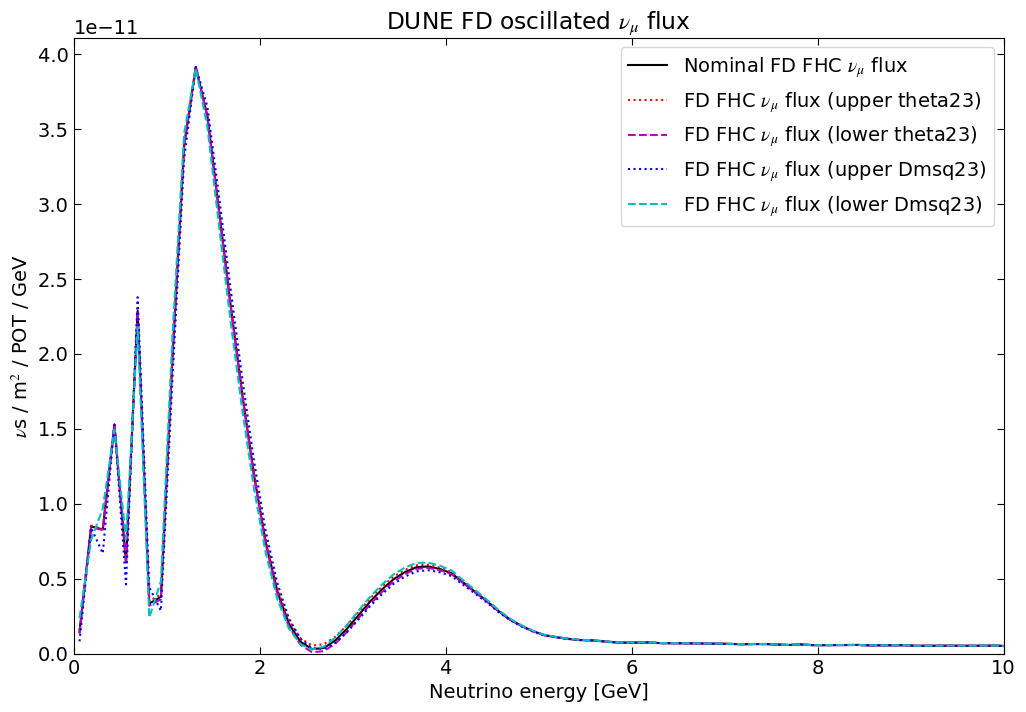

In [3]:
# curves generated from Prob3++ /exp/dune/app/users/yinrui/Oscillation/Prob3-Wrapper/example.C
FDosc_Ev = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,1.1875,1.3125,1.4375,1.5625,1.6875,1.8125,1.9375,2.0625,2.1875,2.3125,2.4375,2.5625,2.6875,2.8125,2.9375,3.0625,3.1875,3.3125,3.4375,3.5625,3.6875,3.8125,3.9375,4.0625,4.1875,4.3125,4.4375,4.5625,4.6875,4.8125,4.9375,5.0625,5.1875,5.3125,5.4375,5.5625,5.6875,5.8125,5.9375,6.0625,6.1875,6.3125,6.4375,6.5625,6.6875,6.8125,6.9375,7.0625,7.1875,7.3125,7.4375,7.5625,7.6875,7.8125,7.9375,8.0625,8.1875,8.3125,8.4375,8.5625,8.6875,8.8125,8.9375,9.0625,9.1875,9.3125,9.4375,9.5625,9.6875,9.8125,9.9375,10.0625,10.1875,10.3125,10.4375,10.5625,10.6875,10.8125,10.9375,11.0625,11.1875,11.3125,11.4375,11.5625,11.6875,11.8125,11.9375,12.0625,12.1875,12.3125,12.4375,12.5625,12.6875,12.8125,12.9375,13.0625,13.1875,13.3125,13.4375,13.5625,13.6875,13.8125,13.9375,14.0625,14.1875,14.3125,14.4375,14.5625,14.6875,14.8125,14.9375,15.0625,15.1875,15.3125,15.4375,15.5625,15.6875,15.8125,15.9375,16.0625,16.1875,16.3125,16.4375,16.5625,16.6875,16.8125,16.9375,17.0625,17.1875,17.3125,17.4375,17.5625,17.6875,17.8125,17.9375,18.0625,18.1875,18.3125,18.4375,18.5625,18.6875,18.8125,18.9375,19.0625,19.1875,19.3125,19.4375,19.5625,19.6875,19.8125,19.9375,20.0625,20.1875,20.3125,20.4375,20.5625,20.6875,20.8125,20.9375,21.0625,21.1875,21.3125,21.4375,21.5625,21.6875,21.8125,21.9375,22.0625,22.1875,22.3125,22.4375,22.5625,22.6875,22.8125,22.9375,23.0625,23.1875,23.3125,23.4375,23.5625,23.6875,23.8125,23.9375,24.0625,24.1875,24.3125,24.4375,24.5625,24.6875,24.8125,24.9375,25.0625,25.1875,25.3125,25.4375,25.5625,25.6875,25.8125,25.9375,26.0625,26.1875,26.3125,26.4375,26.5625,26.6875,26.8125,26.9375,27.0625,27.1875,27.3125,27.4375,27.5625,27.6875,27.8125,27.9375,28.0625,28.1875,28.3125,28.4375,28.5625,28.6875,28.8125,28.9375,29.0625,29.1875,29.3125,29.4375,29.5625,29.6875,29.8125,29.9375,30.0625,30.1875,30.3125,30.4375,30.5625,30.6875,30.8125,30.9375,31.0625,31.1875,31.3125,31.4375,31.5625,31.6875,31.8125,31.9375,32.0625,32.1875,32.3125,32.4375,32.5625,32.6875,32.8125,32.9375,33.0625,33.1875,33.3125,33.4375,33.5625,33.6875,33.8125,33.9375,34.0625,34.1875,34.3125,34.4375,34.5625,34.6875,34.8125,34.9375,35.0625,35.1875,35.3125,35.4375,35.5625,35.6875,35.8125,35.9375,36.0625,36.1875,36.3125,36.4375,36.5625,36.6875,36.8125,36.9375,37.0625,37.1875,37.3125,37.4375,37.5625,37.6875,37.8125,37.9375,38.0625,38.1875,38.3125,38.4375,38.5625,38.6875,38.8125,38.9375,39.0625,39.1875,39.3125,39.4375,39.5625,39.6875,39.8125,39.9375,40.0625,40.1875,40.3125,40.4375,40.5625,40.6875,40.8125,40.9375,41.0625,41.1875,41.3125,41.4375,41.5625,41.6875,41.8125,41.9375,42.0625,42.1875,42.3125,42.4375,42.5625,42.6875,42.8125,42.9375,43.0625,43.1875,43.3125,43.4375,43.5625,43.6875,43.8125,43.9375,44.0625,44.1875,44.3125,44.4375,44.5625,44.6875,44.8125,44.9375,45.0625,45.1875,45.3125,45.4375,45.5625,45.6875,45.8125,45.9375,46.0625,46.1875,46.3125,46.4375,46.5625,46.6875,46.8125,46.9375,47.0625,47.1875,47.3125,47.4375,47.5625,47.6875,47.8125,47.9375,48.0625,48.1875,48.3125,48.4375,48.5625,48.6875,48.8125,48.9375,49.0625,49.1875,49.3125,49.4375,49.5625,49.6875,49.8125,49.9375,50.0625,50.1875,50.3125,50.4375,50.5625,50.6875,50.8125,50.9375,51.0625,51.1875,51.3125,51.4375,51.5625,51.6875,51.8125,51.9375,52.0625,52.1875,52.3125,52.4375,52.5625,52.6875,52.8125,52.9375,53.0625,53.1875,53.3125,53.4375,53.5625,53.6875,53.8125,53.9375,54.0625,54.1875,54.3125,54.4375,54.5625,54.6875,54.8125,54.9375,55.0625,55.1875,55.3125,55.4375,55.5625,55.6875,55.8125,55.9375,56.0625,56.1875,56.3125,56.4375,56.5625,56.6875,56.8125,56.9375,57.0625,57.1875,57.3125,57.4375,57.5625,57.6875,57.8125,57.9375,58.0625,58.1875,58.3125,58.4375,58.5625,58.6875,58.8125,58.9375,59.0625,59.1875,59.3125,59.4375,59.5625,59.6875,59.8125,59.9375,60.0625,60.1875,60.3125,60.4375,60.5625,60.6875,60.8125,60.9375,61.0625,61.1875,61.3125,61.4375,61.5625,61.6875,61.8125,61.9375,62.0625,62.1875,62.3125,62.4375,62.5625,62.6875,62.8125,62.9375,63.0625,63.1875,63.3125,63.4375,63.5625,63.6875,63.8125,63.9375,64.0625,64.1875,64.3125,64.4375,64.5625,64.6875,64.8125,64.9375,65.0625,65.1875,65.3125,65.4375,65.5625,65.6875,65.8125,65.9375,66.0625,66.1875,66.3125,66.4375,66.5625,66.6875,66.8125,66.9375,67.0625,67.1875,67.3125,67.4375,67.5625,67.6875,67.8125,67.9375,68.0625,68.1875,68.3125,68.4375,68.5625,68.6875,68.8125,68.9375,69.0625,69.1875,69.3125,69.4375,69.5625,69.6875,69.8125,69.9375])
ND_Flux_FHCnumu = np.array([2.88412e-05, 5.5657e-05, 6.90372e-05, 9.36508e-05, 0.000131912, 0.000163412, 0.000194663, 0.000223033, 0.000250143, 0.000277031, 0.000288777, 0.000289059, 0.000303559, 0.000324979, 0.000343879, 0.0003572, 0.000360902, 0.000366329, 0.000364808, 0.000360762, 0.000354266, 0.000343475, 0.00032522, 0.000299536, 0.000280358, 0.00025608, 0.000231222, 0.000207731, 0.000176895, 0.000151328, 0.000124887, 0.00010007, 7.78938e-05, 5.86302e-05, 4.4989e-05, 3.26501e-05, 2.47507e-05, 1.8374e-05, 1.4434e-05, 1.22927e-05, 1.0361e-05, 9.78268e-06, 8.96306e-06, 8.00095e-06, 7.35369e-06, 7.23956e-06, 6.84992e-06, 6.83176e-06, 6.32486e-06, 5.9591e-06, 5.74616e-06, 5.93792e-06, 5.91509e-06, 5.48036e-06, 5.37693e-06, 5.12867e-06, 5.13994e-06, 5.08259e-06, 4.67995e-06, 4.5968e-06, 4.69928e-06, 4.51217e-06, 4.4134e-06, 4.54468e-06, 4.33344e-06, 4.33344e-06, 4.33344e-06, 4.33344e-06, 4.17034e-06, 4.17034e-06, 4.17034e-06, 4.17034e-06, 3.88487e-06, 3.88487e-06, 3.88487e-06, 3.88487e-06, 3.75466e-06, 3.75466e-06, 3.75466e-06, 3.75466e-06, 3.60257e-06, 3.60257e-06, 3.60257e-06, 3.60257e-06, 3.44396e-06, 3.44396e-06, 3.44396e-06, 3.44396e-06, 3.19802e-06, 3.19802e-06, 3.19802e-06, 3.19802e-06, 3.06053e-06, 3.06053e-06, 3.06053e-06, 3.06053e-06, 3.00246e-06, 3.00246e-06, 3.00246e-06, 3.00246e-06, 2.85653e-06, 2.85653e-06, 2.85653e-06, 2.85653e-06, 2.71077e-06, 2.71077e-06, 2.71077e-06, 2.71077e-06, 2.42241e-06, 2.42241e-06, 2.42241e-06, 2.42241e-06, 2.2554e-06, 2.2554e-06, 2.2554e-06, 2.2554e-06, 1.94193e-06, 1.94193e-06, 1.94193e-06, 1.94193e-06, 1.68469e-06, 1.68469e-06, 1.68469e-06, 1.68469e-06, 1.48656e-06, 1.48656e-06, 1.48656e-06, 1.48656e-06, 1.17342e-06, 1.17342e-06, 1.17342e-06, 1.17342e-06, 1.15931e-06, 1.15931e-06, 1.15931e-06, 1.15931e-06, 9.43213e-07, 9.43213e-07, 9.43213e-07, 9.43213e-07, 8.41735e-07, 8.41735e-07, 8.41735e-07, 8.41735e-07, 7.70112e-07, 7.70112e-07, 7.70112e-07, 7.70112e-07, 7.20983e-07, 7.20983e-07, 7.20983e-07, 7.20983e-07, 6.21981e-07, 6.21981e-07, 6.21981e-07, 6.21981e-07, 6.01574e-07, 6.01574e-07, 6.01574e-07, 6.01574e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 5.78678e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 4.18653e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 3.18179e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.4146e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 2.06529e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.35478e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 1.18936e-07, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 9.94648e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 7.74895e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 8.64638e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.87245e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 4.23677e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.26685e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 3.37552e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.87013e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 2.39943e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.39799e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.47492e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 1.50919e-08, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 7.37613e-09, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 1.01041e-08, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 7.61707e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 6.13179e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 4.97793e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09, 3.88543e-09])

FDosc_Flux_FHCnumu_1300 = np.array([1.45665e-12,8.4815e-12,8.27856e-12,1.5271e-11,6.08194e-12,2.28604e-11,3.34159e-12,3.78033e-12,1.98519e-11,3.39012e-11,3.9121e-11,3.58217e-11,2.95231e-11,2.3216e-11,1.7298e-11,1.19582e-11,7.48608e-12,4.1935e-12,2.00848e-12,7.91106e-13,2.99613e-13,3.71911e-13,8.75393e-13,1.64957e-12,2.56207e-12,3.47155e-12,4.26377e-12,4.9506e-12,5.43927e-12,5.7645e-12,5.80917e-12,5.64294e-12,5.35631e-12,4.74185e-12,4.13661e-12,3.52893e-12,2.86655e-12,2.29219e-12,1.85686e-12,1.49852e-12,1.22797e-12,1.09599e-12,9.88299e-13,9.06843e-13,8.86857e-13,8.21843e-13,7.54924e-13,7.32672e-13,7.38341e-13,7.45011e-13,6.97402e-13,6.92944e-13,6.91213e-13,6.80321e-13,6.66765e-13,6.62837e-13,6.44675e-13,6.24231e-13,6.37306e-13,6.35722e-13,6.01978e-13,5.75012e-13,6.1171e-13,5.65918e-13,5.62034e-13,5.66821e-13,5.71418e-13,5.75835e-13,5.45809e-13,5.49651e-13,5.53348e-13,5.56906e-13,5.18324e-13,5.21377e-13,5.24318e-13,5.27154e-13,5.21088e-13,5.23683e-13,5.26187e-13,5.28605e-13,4.81356e-13,4.83401e-13,4.85378e-13,4.8729e-13,4.5407e-13,4.55731e-13,4.57338e-13,4.58894e-13,4.37273e-13,4.38659e-13,4.40002e-13,4.41304e-13,4.13116e-13,4.14259e-13,4.15368e-13,4.16444e-13,3.97532e-13,3.98498e-13,3.99436e-13,4.00348e-13,3.7189e-13,3.72687e-13,3.73463e-13,3.74217e-13,3.5979e-13,3.60475e-13,3.61141e-13,3.6179e-13,3.36345e-13,3.36916e-13,3.37472e-13,3.38014e-13,3.19136e-13,3.19621e-13,3.20094e-13,3.20555e-13,2.96545e-13,2.96951e-13,2.97346e-13,2.97732e-13,2.93884e-13,2.94246e-13,2.946e-13,2.94946e-13,2.67801e-13,2.681e-13,2.68393e-13,2.68678e-13,2.33293e-13,2.3353e-13,2.33761e-13,2.33987e-13,2.16133e-13,2.16333e-13,2.16528e-13,2.1672e-13,1.91534e-13,1.91696e-13,1.91854e-13,1.92009e-13,1.62623e-13,1.62749e-13,1.62872e-13,1.62993e-13,1.3503e-13,1.35126e-13,1.3522e-13,1.35312e-13,1.21751e-13,1.21831e-13,1.21909e-13,1.21986e-13,1.09195e-13,1.09261e-13,1.09325e-13,1.09389e-13,1.0236e-13,1.02417e-13,1.02473e-13,1.02528e-13,9.63199e-14,9.63697e-14,9.64187e-14,9.64668e-14,9.6514e-14,9.65604e-14,9.66059e-14,9.66507e-14,9.66947e-14,9.67379e-14,9.67804e-14,9.68221e-14,9.68632e-14,9.69035e-14,9.69432e-14,9.69822e-14,7.93789e-14,7.94097e-14,7.94401e-14,7.94699e-14,7.94993e-14,7.95282e-14,7.95566e-14,7.95845e-14,7.9612e-14,7.96391e-14,7.96657e-14,7.9692e-14,7.97178e-14,7.97432e-14,7.97682e-14,7.97928e-14,6.28433e-14,6.28621e-14,6.28806e-14,6.28989e-14,6.29168e-14,6.29345e-14,6.2952e-14,6.29691e-14,6.29861e-14,6.30027e-14,6.30192e-14,6.30353e-14,6.30513e-14,6.3067e-14,6.30825e-14,6.30978e-14,4.94605e-14,4.94722e-14,4.94836e-14,4.94949e-14,4.95061e-14,4.95171e-14,4.9528e-14,4.95386e-14,4.95492e-14,4.95596e-14,4.95699e-14,4.958e-14,4.959e-14,4.95999e-14,4.96096e-14,4.96192e-14,3.87453e-14,3.87526e-14,3.87598e-14,3.87669e-14,3.87739e-14,3.87808e-14,3.87877e-14,3.87944e-14,3.88011e-14,3.88077e-14,3.88141e-14,3.88206e-14,3.88269e-14,3.88331e-14,3.88393e-14,3.88454e-14,3.36188e-14,3.36239e-14,3.3629e-14,3.3634e-14,3.3639e-14,3.36439e-14,3.36487e-14,3.36535e-14,3.36582e-14,3.36629e-14,3.36675e-14,3.36721e-14,3.36766e-14,3.3681e-14,3.36854e-14,3.36898e-14,2.46367e-14,2.46398e-14,2.46429e-14,2.46459e-14,2.46489e-14,2.46519e-14,2.46548e-14,2.46578e-14,2.46606e-14,2.46635e-14,2.46663e-14,2.4669e-14,2.46718e-14,2.46745e-14,2.46772e-14,2.46798e-14,1.84236e-14,1.84255e-14,1.84274e-14,1.84293e-14,1.84312e-14,1.84331e-14,1.84349e-14,1.84367e-14,1.84385e-14,1.84403e-14,1.8442e-14,1.84438e-14,1.84455e-14,1.84472e-14,1.84489e-14,1.84506e-14,1.58983e-14,1.58997e-14,1.59011e-14,1.59024e-14,1.59038e-14,1.59052e-14,1.59065e-14,1.59078e-14,1.59091e-14,1.59104e-14,1.59117e-14,1.5913e-14,1.59143e-14,1.59155e-14,1.59167e-14,1.5918e-14,1.43894e-14,1.43905e-14,1.43915e-14,1.43926e-14,1.43936e-14,1.43947e-14,1.43957e-14,1.43967e-14,1.43978e-14,1.43988e-14,1.43998e-14,1.44007e-14,1.44017e-14,1.44027e-14,1.44036e-14,1.44046e-14,1.05131e-14,1.05138e-14,1.05145e-14,1.05152e-14,1.05158e-14,1.05165e-14,1.05171e-14,1.05178e-14,1.05184e-14,1.0519e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,8.75632e-15,8.75681e-15,8.7573e-15,8.75778e-15,8.75825e-15,8.75873e-15,8.75919e-15,8.75966e-15,8.76012e-15,8.76057e-15,8.76102e-15,8.76147e-15,8.76192e-15,8.76236e-15,8.76279e-15,8.76323e-15,7.98481e-15,7.9852e-15,7.98558e-15,7.98597e-15,7.98634e-15,7.98672e-15,7.98709e-15,7.98746e-15,7.98783e-15,7.98819e-15,7.98855e-15,7.9889e-15,7.98926e-15,7.98961e-15,7.98996e-15,7.9903e-15,6.55704e-15,6.55732e-15,6.5576e-15,6.55787e-15,6.55814e-15,6.55841e-15,6.55868e-15,6.55895e-15,6.55921e-15,6.55947e-15,6.55973e-15,6.55999e-15,6.56024e-15,6.5605e-15,6.56075e-15,6.561e-15,4.69919e-15,4.69936e-15,4.69954e-15,4.69971e-15,4.69988e-15,4.70005e-15,4.70022e-15,4.70039e-15,4.70056e-15,4.70072e-15,4.70089e-15,4.70105e-15,4.70121e-15,4.70137e-15,4.70153e-15,4.70169e-15,4.42933e-15,4.42948e-15,4.42962e-15,4.42977e-15,4.42991e-15,4.43005e-15,4.4302e-15,4.43034e-15,4.43048e-15,4.43061e-15,4.43075e-15,4.43089e-15,4.43102e-15,4.43116e-15,4.43129e-15,4.43142e-15,3.22516e-15,3.22525e-15,3.22535e-15,3.22544e-15,3.22553e-15,3.22563e-15,3.22572e-15,3.22581e-15,3.2259e-15,3.22599e-15,3.22608e-15,3.22617e-15,3.22625e-15,3.22634e-15,3.22643e-15,3.22651e-15,2.55828e-15,2.55835e-15,2.55841e-15,2.55848e-15,2.55854e-15,2.55861e-15,2.55867e-15,2.55874e-15,2.5588e-15,2.55887e-15,2.55893e-15,2.55899e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.81248e-15,2.81254e-15,2.81261e-15,2.81268e-15,2.81274e-15,2.81281e-15,2.81287e-15,2.81293e-15,2.813e-15,2.81306e-15,2.81312e-15,2.81318e-15,2.81325e-15,2.81331e-15,2.81337e-15,2.81343e-15,1.6984e-15,1.69844e-15,1.69847e-15,1.69851e-15,1.69854e-15,1.69858e-15,1.69861e-15,1.69865e-15,1.69868e-15,1.69872e-15,1.69875e-15,1.69878e-15,1.69882e-15,1.69885e-15,1.69888e-15,1.69892e-15,1.88869e-15,1.88872e-15,1.88876e-15,1.88879e-15,1.88883e-15,1.88886e-15,1.8889e-15,1.88893e-15,1.88897e-15,1.889e-15,1.88904e-15,1.88907e-15,1.88911e-15,1.88914e-15,1.88917e-15,1.88921e-15,1.28502e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.40804e-16,9.40819e-16,9.40834e-16,9.40848e-16,9.40863e-16,9.40877e-16,9.40892e-16,9.40906e-16,9.4092e-16,9.40935e-16,9.40949e-16,9.40963e-16,9.40977e-16,9.40991e-16,9.41004e-16,9.41018e-16,1.29694e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.2972e-15,7.29158e-16,7.29168e-16,7.29177e-16,7.29187e-16,7.29196e-16,7.29206e-16,7.29215e-16,7.29224e-16,7.29234e-16,7.29243e-16,7.29252e-16,7.29261e-16,7.2927e-16,7.29279e-16,7.29288e-16,7.29297e-16])
FDosc_Flux_FHCnumu_t23p = np.array([1.55477e-12,8.53591e-12,8.30342e-12,1.52841e-11,6.16843e-12,2.28817e-11,3.49777e-12,3.95173e-12,1.99437e-11,3.39221e-11,3.91144e-11,3.58264e-11,2.95592e-11,2.32923e-11,1.74167e-11,1.21159e-11,7.67355e-12,4.40202e-12,2.22908e-12,1.0213e-12,5.36652e-13,6.15437e-13,1.11997e-12,1.88506e-12,2.78434e-12,3.67632e-12,4.44796e-12,5.11553e-12,5.58441e-12,5.89124e-12,5.91678e-12,5.73258e-12,5.43034e-12,4.79955e-12,4.18137e-12,3.56318e-12,2.8917e-12,2.31048e-12,1.87041e-12,1.50857e-12,1.23557e-12,1.10228e-12,9.93573e-13,9.11358e-13,8.90989e-13,8.25436e-13,7.5803e-13,7.35513e-13,7.41046e-13,7.47595e-13,6.99696e-13,6.9511e-13,6.93267e-13,6.82248e-13,6.68567e-13,6.64548e-13,6.46267e-13,6.25707e-13,6.38751e-13,6.37105e-13,6.03236e-13,5.76167e-13,6.12893e-13,5.66972e-13,5.63043e-13,5.67802e-13,5.72373e-13,5.76765e-13,5.46661e-13,5.50481e-13,5.54157e-13,5.57694e-13,5.19035e-13,5.2207e-13,5.24995e-13,5.27814e-13,5.21721e-13,5.24301e-13,5.26791e-13,5.29195e-13,4.81878e-13,4.83912e-13,4.85877e-13,4.87778e-13,4.54514e-13,4.56164e-13,4.57762e-13,4.59309e-13,4.37659e-13,4.39037e-13,4.40372e-13,4.41667e-13,4.13448e-13,4.14584e-13,4.15687e-13,4.16757e-13,3.97824e-13,3.98784e-13,3.99716e-13,4.00622e-13,3.7214e-13,3.72933e-13,3.73704e-13,3.74454e-13,3.60012e-13,3.60693e-13,3.61356e-13,3.62001e-13,3.36537e-13,3.37105e-13,3.37658e-13,3.38196e-13,3.19305e-13,3.19788e-13,3.20258e-13,3.20716e-13,2.96691e-13,2.97094e-13,2.97487e-13,2.97871e-13,2.94019e-13,2.94379e-13,2.94731e-13,2.95074e-13,2.67916e-13,2.68214e-13,2.68504e-13,2.68788e-13,2.33387e-13,2.33622e-13,2.33852e-13,2.34077e-13,2.16215e-13,2.16413e-13,2.16608e-13,2.16798e-13,1.91602e-13,1.91763e-13,1.9192e-13,1.92075e-13,1.62677e-13,1.62803e-13,1.62925e-13,1.63045e-13,1.35072e-13,1.35168e-13,1.35261e-13,1.35353e-13,1.21788e-13,1.21867e-13,1.21945e-13,1.22021e-13,1.09226e-13,1.09291e-13,1.09355e-13,1.09419e-13,1.02388e-13,1.02444e-13,1.025e-13,1.02555e-13,9.63444e-14,9.63939e-14,9.64426e-14,9.64904e-14,9.65374e-14,9.65835e-14,9.66288e-14,9.66733e-14,9.6717e-14,9.676e-14,9.68022e-14,9.68437e-14,9.68845e-14,9.69246e-14,9.6964e-14,9.70027e-14,7.93955e-14,7.94262e-14,7.94564e-14,7.9486e-14,7.95152e-14,7.95439e-14,7.95722e-14,7.95999e-14,7.96273e-14,7.96542e-14,7.96807e-14,7.97067e-14,7.97324e-14,7.97577e-14,7.97825e-14,7.9807e-14,6.28544e-14,6.28731e-14,6.28915e-14,6.29096e-14,6.29275e-14,6.2945e-14,6.29624e-14,6.29794e-14,6.29963e-14,6.30128e-14,6.30292e-14,6.30452e-14,6.30611e-14,6.30767e-14,6.30921e-14,6.31073e-14,4.94679e-14,4.94795e-14,4.94909e-14,4.95021e-14,4.95132e-14,4.95242e-14,4.95349e-14,4.95456e-14,4.95561e-14,4.95664e-14,4.95766e-14,4.95867e-14,4.95966e-14,4.96064e-14,4.96161e-14,4.96256e-14,3.87503e-14,3.87575e-14,3.87647e-14,3.87718e-14,3.87787e-14,3.87856e-14,3.87924e-14,3.87991e-14,3.88057e-14,3.88123e-14,3.88187e-14,3.88251e-14,3.88314e-14,3.88376e-14,3.88437e-14,3.88498e-14,3.36225e-14,3.36277e-14,3.36327e-14,3.36377e-14,3.36426e-14,3.36475e-14,3.36523e-14,3.36571e-14,3.36618e-14,3.36664e-14,3.3671e-14,3.36755e-14,3.368e-14,3.36844e-14,3.36888e-14,3.36931e-14,2.46392e-14,2.46422e-14,2.46453e-14,2.46483e-14,2.46513e-14,2.46543e-14,2.46572e-14,2.46601e-14,2.46629e-14,2.46657e-14,2.46685e-14,2.46713e-14,2.4674e-14,2.46767e-14,2.46794e-14,2.4682e-14,1.84252e-14,1.84271e-14,1.8429e-14,1.84309e-14,1.84328e-14,1.84346e-14,1.84364e-14,1.84382e-14,1.844e-14,1.84418e-14,1.84435e-14,1.84453e-14,1.8447e-14,1.84487e-14,1.84504e-14,1.8452e-14,1.58995e-14,1.59009e-14,1.59023e-14,1.59037e-14,1.5905e-14,1.59064e-14,1.59077e-14,1.5909e-14,1.59103e-14,1.59116e-14,1.59129e-14,1.59141e-14,1.59154e-14,1.59166e-14,1.59179e-14,1.59191e-14,1.43904e-14,1.43914e-14,1.43925e-14,1.43936e-14,1.43946e-14,1.43957e-14,1.43967e-14,1.43977e-14,1.43987e-14,1.43997e-14,1.44007e-14,1.44017e-14,1.44026e-14,1.44036e-14,1.44046e-14,1.44055e-14,1.05138e-14,1.05145e-14,1.05151e-14,1.05158e-14,1.05165e-14,1.05171e-14,1.05178e-14,1.05184e-14,1.0519e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,1.05233e-14,8.75682e-15,8.75731e-15,8.75779e-15,8.75827e-15,8.75874e-15,8.75921e-15,8.75968e-15,8.76014e-15,8.76059e-15,8.76105e-15,8.7615e-15,8.76194e-15,8.76238e-15,8.76282e-15,8.76325e-15,8.76368e-15,7.98523e-15,7.98561e-15,7.986e-15,7.98637e-15,7.98675e-15,7.98712e-15,7.98749e-15,7.98786e-15,7.98822e-15,7.98858e-15,7.98894e-15,7.98929e-15,7.98965e-15,7.99e-15,7.99034e-15,7.99068e-15,6.55735e-15,6.55763e-15,6.55791e-15,6.55818e-15,6.55845e-15,6.55872e-15,6.55898e-15,6.55925e-15,6.55951e-15,6.55977e-15,6.56003e-15,6.56028e-15,6.56054e-15,6.56079e-15,6.56104e-15,6.56129e-15,4.69939e-15,4.69957e-15,4.69974e-15,4.69991e-15,4.70008e-15,4.70025e-15,4.70042e-15,4.70059e-15,4.70075e-15,4.70092e-15,4.70108e-15,4.70124e-15,4.7014e-15,4.70156e-15,4.70172e-15,4.70188e-15,4.42951e-15,4.42966e-15,4.4298e-15,4.42994e-15,4.43009e-15,4.43023e-15,4.43037e-15,4.43051e-15,4.43065e-15,4.43078e-15,4.43092e-15,4.43106e-15,4.43119e-15,4.43132e-15,4.43146e-15,4.43159e-15,3.22528e-15,3.22537e-15,3.22547e-15,3.22556e-15,3.22565e-15,3.22574e-15,3.22583e-15,3.22592e-15,3.22601e-15,3.2261e-15,3.22619e-15,3.22628e-15,3.22637e-15,3.22645e-15,3.22654e-15,3.22663e-15,2.55837e-15,2.55843e-15,2.5585e-15,2.55857e-15,2.55863e-15,2.5587e-15,2.55876e-15,2.55883e-15,2.55889e-15,2.55895e-15,2.55901e-15,2.55908e-15,2.55914e-15,2.5592e-15,2.55926e-15,2.55932e-15,2.81257e-15,2.81263e-15,2.8127e-15,2.81277e-15,2.81283e-15,2.81289e-15,2.81296e-15,2.81302e-15,2.81308e-15,2.81315e-15,2.81321e-15,2.81327e-15,2.81333e-15,2.81339e-15,2.81345e-15,2.81351e-15,1.69845e-15,1.69849e-15,1.69852e-15,1.69856e-15,1.69859e-15,1.69863e-15,1.69866e-15,1.6987e-15,1.69873e-15,1.69877e-15,1.6988e-15,1.69883e-15,1.69887e-15,1.6989e-15,1.69893e-15,1.69897e-15,1.88874e-15,1.88878e-15,1.88881e-15,1.88885e-15,1.88888e-15,1.88892e-15,1.88895e-15,1.88899e-15,1.88902e-15,1.88905e-15,1.88909e-15,1.88912e-15,1.88916e-15,1.88919e-15,1.88922e-15,1.88926e-15,1.28506e-15,1.28508e-15,1.2851e-15,1.28512e-15,1.28514e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28534e-15,1.28536e-15,1.28538e-15,9.40827e-16,9.40842e-16,9.40857e-16,9.40871e-16,9.40886e-16,9.409e-16,9.40914e-16,9.40929e-16,9.40943e-16,9.40957e-16,9.40971e-16,9.40985e-16,9.40999e-16,9.41013e-16,9.41026e-16,9.4104e-16,1.29697e-15,1.29698e-15,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.29709e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29716e-15,1.29718e-15,1.2972e-15,1.29722e-15,1.29723e-15,7.29174e-16,7.29184e-16,7.29193e-16,7.29203e-16,7.29212e-16,7.29221e-16,7.29231e-16,7.2924e-16,7.29249e-16,7.29258e-16,7.29267e-16,7.29276e-16,7.29285e-16,7.29294e-16,7.29303e-16,7.29312e-16])
FDosc_Flux_FHCnumu_t23m = np.array([1.32444e-12,8.40522e-12,8.25221e-12,1.52521e-11,6.00359e-12,2.28367e-11,3.1969e-12,3.62344e-12,1.97674e-11,3.38823e-11,3.91296e-11,3.58227e-11,2.94979e-11,2.31562e-11,1.72011e-11,1.18269e-11,7.32784e-12,4.01585e-12,1.81921e-12,5.9251e-13,9.4186e-14,1.60053e-13,6.61919e-13,1.44344e-12,2.36702e-12,3.29145e-12,4.10145e-12,4.80497e-12,5.31092e-12,5.65223e-12,5.71372e-12,5.56333e-12,5.29048e-12,4.69048e-12,4.09671e-12,3.49837e-12,2.8441e-12,2.27585e-12,1.84475e-12,1.48953e-12,1.22116e-12,1.09035e-12,9.83569e-13,9.0279e-13,8.83145e-13,8.18613e-13,7.52132e-13,7.30115e-13,7.35905e-13,7.42684e-13,6.95335e-13,6.90993e-13,6.8936e-13,6.78583e-13,6.65139e-13,6.61292e-13,6.43237e-13,6.22897e-13,6.36e-13,6.34472e-13,6.0084e-13,5.73967e-13,6.1064e-13,5.64964e-13,5.6112e-13,5.65932e-13,5.70553e-13,5.74993e-13,5.45036e-13,5.48899e-13,5.52615e-13,5.56191e-13,5.17679e-13,5.20748e-13,5.23705e-13,5.26556e-13,5.20513e-13,5.23121e-13,5.25639e-13,5.28069e-13,4.80881e-13,4.82937e-13,4.84925e-13,4.86846e-13,4.53668e-13,4.55337e-13,4.56952e-13,4.58516e-13,4.36922e-13,4.38315e-13,4.39666e-13,4.40975e-13,4.12815e-13,4.13964e-13,4.15079e-13,4.1616e-13,3.97267e-13,3.98238e-13,3.99181e-13,4.00097e-13,3.71662e-13,3.72464e-13,3.73244e-13,3.74002e-13,3.59587e-13,3.60275e-13,3.60946e-13,3.61598e-13,3.3617e-13,3.36744e-13,3.37303e-13,3.37847e-13,3.18982e-13,3.1947e-13,3.19945e-13,3.20409e-13,2.96412e-13,2.96819e-13,2.97217e-13,2.97605e-13,2.93761e-13,2.94125e-13,2.94481e-13,2.94828e-13,2.67696e-13,2.67997e-13,2.68291e-13,2.68578e-13,2.33207e-13,2.33445e-13,2.33678e-13,2.33905e-13,2.16059e-13,2.1626e-13,2.16456e-13,2.16648e-13,1.91472e-13,1.91635e-13,1.91794e-13,1.9195e-13,1.62573e-13,1.627e-13,1.62824e-13,1.62945e-13,1.34991e-13,1.35087e-13,1.35182e-13,1.35275e-13,1.21718e-13,1.21798e-13,1.21877e-13,1.21954e-13,1.09166e-13,1.09233e-13,1.09298e-13,1.09362e-13,1.02335e-13,1.02392e-13,1.02449e-13,1.02504e-13,9.62974e-14,9.63476e-14,9.63968e-14,9.64451e-14,9.64926e-14,9.65393e-14,9.65851e-14,9.66301e-14,9.66743e-14,9.67178e-14,9.67605e-14,9.68024e-14,9.68437e-14,9.68842e-14,9.69241e-14,9.69633e-14,7.93636e-14,7.93947e-14,7.94252e-14,7.94552e-14,7.94847e-14,7.95137e-14,7.95423e-14,7.95704e-14,7.9598e-14,7.96253e-14,7.9652e-14,7.96784e-14,7.97044e-14,7.97299e-14,7.97551e-14,7.97798e-14,6.28332e-14,6.28521e-14,6.28707e-14,6.28891e-14,6.29071e-14,6.29249e-14,6.29424e-14,6.29597e-14,6.29767e-14,6.29935e-14,6.301e-14,6.30263e-14,6.30423e-14,6.30581e-14,6.30737e-14,6.30891e-14,4.94537e-14,4.94654e-14,4.9477e-14,4.94884e-14,4.94996e-14,4.95106e-14,4.95215e-14,4.95323e-14,4.95429e-14,4.95534e-14,4.95637e-14,4.95739e-14,4.95839e-14,4.95938e-14,4.96036e-14,4.96133e-14,3.87407e-14,3.8748e-14,3.87553e-14,3.87624e-14,3.87695e-14,3.87764e-14,3.87833e-14,3.87901e-14,3.87968e-14,3.88034e-14,3.88099e-14,3.88164e-14,3.88228e-14,3.8829e-14,3.88353e-14,3.88414e-14,3.36153e-14,3.36205e-14,3.36256e-14,3.36306e-14,3.36356e-14,3.36406e-14,3.36454e-14,3.36502e-14,3.3655e-14,3.36597e-14,3.36643e-14,3.36689e-14,3.36734e-14,3.36779e-14,3.36824e-14,3.36867e-14,2.46345e-14,2.46376e-14,2.46407e-14,2.46438e-14,2.46468e-14,2.46498e-14,2.46527e-14,2.46556e-14,2.46585e-14,2.46614e-14,2.46642e-14,2.4667e-14,2.46697e-14,2.46725e-14,2.46752e-14,2.46778e-14,1.84221e-14,1.8424e-14,1.8426e-14,1.84279e-14,1.84298e-14,1.84316e-14,1.84335e-14,1.84353e-14,1.84371e-14,1.84389e-14,1.84407e-14,1.84424e-14,1.84441e-14,1.84459e-14,1.84476e-14,1.84492e-14,1.58971e-14,1.58985e-14,1.58999e-14,1.59013e-14,1.59027e-14,1.59041e-14,1.59054e-14,1.59067e-14,1.59081e-14,1.59094e-14,1.59107e-14,1.59119e-14,1.59132e-14,1.59145e-14,1.59157e-14,1.59169e-14,1.43884e-14,1.43895e-14,1.43906e-14,1.43917e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43959e-14,1.43969e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44009e-14,1.44018e-14,1.44028e-14,1.44037e-14,1.05125e-14,1.05132e-14,1.05139e-14,1.05146e-14,1.05152e-14,1.05159e-14,1.05165e-14,1.05172e-14,1.05178e-14,1.05185e-14,1.05191e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,8.75586e-15,8.75636e-15,8.75684e-15,8.75733e-15,8.7578e-15,8.75828e-15,8.75875e-15,8.75922e-15,8.75968e-15,8.76014e-15,8.76059e-15,8.76104e-15,8.76149e-15,8.76193e-15,8.76237e-15,8.7628e-15,7.98443e-15,7.98482e-15,7.98521e-15,7.98559e-15,7.98597e-15,7.98635e-15,7.98672e-15,7.98709e-15,7.98746e-15,7.98782e-15,7.98819e-15,7.98854e-15,7.9889e-15,7.98925e-15,7.9896e-15,7.98995e-15,6.55676e-15,6.55704e-15,6.55731e-15,6.55759e-15,6.55786e-15,6.55813e-15,6.5584e-15,6.55867e-15,6.55894e-15,6.5592e-15,6.55946e-15,6.55972e-15,6.55997e-15,6.56023e-15,6.56048e-15,6.56073e-15,4.699e-15,4.69918e-15,4.69935e-15,4.69953e-15,4.6997e-15,4.69987e-15,4.70004e-15,4.70021e-15,4.70038e-15,4.70054e-15,4.70071e-15,4.70087e-15,4.70103e-15,4.70119e-15,4.70135e-15,4.70151e-15,4.42917e-15,4.42932e-15,4.42946e-15,4.42961e-15,4.42975e-15,4.42989e-15,4.43004e-15,4.43018e-15,4.43032e-15,4.43046e-15,4.43059e-15,4.43073e-15,4.43087e-15,4.431e-15,4.43114e-15,4.43127e-15,3.22505e-15,3.22514e-15,3.22524e-15,3.22533e-15,3.22542e-15,3.22552e-15,3.22561e-15,3.2257e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22624e-15,3.22632e-15,3.22641e-15,2.5582e-15,2.55826e-15,2.55833e-15,2.5584e-15,2.55846e-15,2.55853e-15,2.5586e-15,2.55866e-15,2.55873e-15,2.55879e-15,2.55885e-15,2.55892e-15,2.55898e-15,2.55904e-15,2.5591e-15,2.55916e-15,2.8124e-15,2.81246e-15,2.81253e-15,2.81259e-15,2.81266e-15,2.81272e-15,2.81279e-15,2.81285e-15,2.81292e-15,2.81298e-15,2.81304e-15,2.8131e-15,2.81317e-15,2.81323e-15,2.81329e-15,2.81335e-15,1.69835e-15,1.69839e-15,1.69843e-15,1.69846e-15,1.6985e-15,1.69853e-15,1.69857e-15,1.6986e-15,1.69864e-15,1.69867e-15,1.69871e-15,1.69874e-15,1.69877e-15,1.69881e-15,1.69884e-15,1.69887e-15,1.88864e-15,1.88867e-15,1.88871e-15,1.88875e-15,1.88878e-15,1.88882e-15,1.88885e-15,1.88889e-15,1.88892e-15,1.88896e-15,1.88899e-15,1.88903e-15,1.88906e-15,1.88909e-15,1.88913e-15,1.88916e-15,1.28499e-15,1.28501e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.2851e-15,1.28512e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28532e-15,9.40783e-16,9.40798e-16,9.40812e-16,9.40827e-16,9.40842e-16,9.40857e-16,9.40871e-16,9.40885e-16,9.409e-16,9.40914e-16,9.40928e-16,9.40942e-16,9.40956e-16,9.4097e-16,9.40984e-16,9.40998e-16,1.29691e-15,1.29693e-15,1.29695e-15,1.29696e-15,1.29698e-15,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29707e-15,1.29709e-15,1.29711e-15,1.29713e-15,1.29714e-15,1.29716e-15,1.29718e-15,7.29144e-16,7.29153e-16,7.29163e-16,7.29172e-16,7.29182e-16,7.29191e-16,7.29201e-16,7.2921e-16,7.29219e-16,7.29229e-16,7.29238e-16,7.29247e-16,7.29256e-16,7.29265e-16,7.29274e-16,7.29283e-16])
FDosc_Flux_FHCnumu_t232p = np.array([1.65588e-12,8.5902e-12,8.33336e-12,1.52969e-11,6.28043e-12,2.29066e-11,3.69798e-12,4.17265e-12,2.00619e-11,3.39492e-11,3.91075e-11,3.58355e-11,2.96104e-11,2.33964e-11,1.75767e-11,1.23267e-11,7.92303e-12,4.67854e-12,2.52087e-12,1.32513e-12,8.48957e-13,9.35814e-13,1.44133e-12,2.19412e-12,3.07576e-12,3.94455e-12,4.68903e-12,5.33126e-12,5.7741e-12,6.0568e-12,6.05726e-12,5.84955e-12,5.52688e-12,4.87476e-12,4.2397e-12,3.6078e-12,2.92443e-12,2.33428e-12,1.88803e-12,1.52164e-12,1.24545e-12,1.11045e-12,1.00043e-12,9.17225e-13,8.96357e-13,8.30103e-13,7.62062e-13,7.39202e-13,7.44557e-13,7.50948e-13,7.02672e-13,6.97918e-13,6.95932e-13,6.84747e-13,6.70903e-13,6.66766e-13,6.48331e-13,6.2762e-13,6.40623e-13,6.38897e-13,6.04865e-13,5.77664e-13,6.14425e-13,5.68337e-13,5.64349e-13,5.69072e-13,5.73609e-13,5.77969e-13,5.47763e-13,5.51555e-13,5.55203e-13,5.58714e-13,5.19954e-13,5.22966e-13,5.25869e-13,5.28668e-13,5.2254e-13,5.25101e-13,5.27572e-13,5.29958e-13,4.82554e-13,4.84572e-13,4.86523e-13,4.88409e-13,4.55086e-13,4.56725e-13,4.5831e-13,4.59845e-13,4.38157e-13,4.39525e-13,4.4085e-13,4.42135e-13,4.13876e-13,4.15004e-13,4.16098e-13,4.1716e-13,3.982e-13,3.99153e-13,4.00078e-13,4.00977e-13,3.72462e-13,3.73249e-13,3.74015e-13,3.74759e-13,3.603e-13,3.60976e-13,3.61633e-13,3.62273e-13,3.36785e-13,3.37349e-13,3.37897e-13,3.38432e-13,3.19524e-13,3.20002e-13,3.20469e-13,3.20924e-13,2.9688e-13,2.9728e-13,2.9767e-13,2.9805e-13,2.94193e-13,2.9455e-13,2.94899e-13,2.9524e-13,2.68064e-13,2.6836e-13,2.68648e-13,2.6893e-13,2.33508e-13,2.33741e-13,2.33969e-13,2.34193e-13,2.1632e-13,2.16517e-13,2.1671e-13,2.16898e-13,1.9169e-13,1.91849e-13,1.92006e-13,1.92159e-13,1.62748e-13,1.62872e-13,1.62993e-13,1.63113e-13,1.35127e-13,1.35222e-13,1.35315e-13,1.35406e-13,1.21834e-13,1.21913e-13,1.2199e-13,1.22066e-13,1.09265e-13,1.0933e-13,1.09394e-13,1.09457e-13,1.02423e-13,1.02479e-13,1.02535e-13,1.02589e-13,9.6376e-14,9.64252e-14,9.64735e-14,9.65209e-14,9.65675e-14,9.66132e-14,9.66582e-14,9.67023e-14,9.67457e-14,9.67883e-14,9.68302e-14,9.68714e-14,9.69119e-14,9.69517e-14,9.69908e-14,9.70293e-14,7.9417e-14,7.94474e-14,7.94773e-14,7.95068e-14,7.95357e-14,7.95642e-14,7.95922e-14,7.96198e-14,7.96469e-14,7.96736e-14,7.96999e-14,7.97258e-14,7.97512e-14,7.97763e-14,7.9801e-14,7.98253e-14,6.28686e-14,6.28872e-14,6.29054e-14,6.29234e-14,6.29411e-14,6.29586e-14,6.29758e-14,6.29927e-14,6.30094e-14,6.30258e-14,6.3042e-14,6.3058e-14,6.30737e-14,6.30893e-14,6.31045e-14,6.31196e-14,4.94775e-14,4.94889e-14,4.95003e-14,4.95114e-14,4.95224e-14,4.95333e-14,4.9544e-14,4.95545e-14,4.95649e-14,4.95752e-14,4.95853e-14,4.95953e-14,4.96052e-14,4.96149e-14,4.96245e-14,4.96339e-14,3.87567e-14,3.87639e-14,3.8771e-14,3.8778e-14,3.87849e-14,3.87918e-14,3.87985e-14,3.88052e-14,3.88117e-14,3.88182e-14,3.88246e-14,3.8831e-14,3.88372e-14,3.88434e-14,3.88495e-14,3.88555e-14,3.36274e-14,3.36325e-14,3.36375e-14,3.36424e-14,3.36473e-14,3.36522e-14,3.36569e-14,3.36617e-14,3.36663e-14,3.36709e-14,3.36755e-14,3.368e-14,3.36844e-14,3.36888e-14,3.36932e-14,3.36975e-14,2.46423e-14,2.46453e-14,2.46484e-14,2.46514e-14,2.46543e-14,2.46573e-14,2.46602e-14,2.4663e-14,2.46658e-14,2.46686e-14,2.46714e-14,2.46741e-14,2.46769e-14,2.46795e-14,2.46822e-14,2.46848e-14,1.84272e-14,1.84292e-14,1.84311e-14,1.84329e-14,1.84348e-14,1.84366e-14,1.84384e-14,1.84402e-14,1.8442e-14,1.84437e-14,1.84455e-14,1.84472e-14,1.84489e-14,1.84506e-14,1.84522e-14,1.84539e-14,1.59011e-14,1.59025e-14,1.59039e-14,1.59052e-14,1.59066e-14,1.59079e-14,1.59092e-14,1.59105e-14,1.59118e-14,1.59131e-14,1.59144e-14,1.59156e-14,1.59169e-14,1.59181e-14,1.59193e-14,1.59205e-14,1.43917e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43959e-14,1.43969e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44009e-14,1.44019e-14,1.44029e-14,1.44038e-14,1.44048e-14,1.44057e-14,1.44067e-14,1.05147e-14,1.05153e-14,1.0516e-14,1.05166e-14,1.05173e-14,1.05179e-14,1.05186e-14,1.05192e-14,1.05198e-14,1.05205e-14,1.05211e-14,1.05217e-14,1.05223e-14,1.05229e-14,1.05235e-14,1.05241e-14,8.75747e-15,8.75795e-15,8.75843e-15,8.7589e-15,8.75937e-15,8.75984e-15,8.7603e-15,8.76075e-15,8.76121e-15,8.76166e-15,8.7621e-15,8.76254e-15,8.76298e-15,8.76342e-15,8.76385e-15,8.76427e-15,7.98576e-15,7.98615e-15,7.98652e-15,7.9869e-15,7.98727e-15,7.98764e-15,7.98801e-15,7.98837e-15,7.98873e-15,7.98909e-15,7.98945e-15,7.9898e-15,7.99015e-15,7.99049e-15,7.99084e-15,7.99118e-15,6.55776e-15,6.55803e-15,6.5583e-15,6.55857e-15,6.55884e-15,6.55911e-15,6.55937e-15,6.55963e-15,6.55989e-15,6.56015e-15,6.56041e-15,6.56066e-15,6.56091e-15,6.56116e-15,6.56141e-15,6.56166e-15,4.69966e-15,4.69983e-15,4.7e-15,4.70017e-15,4.70034e-15,4.70051e-15,4.70068e-15,4.70084e-15,4.70101e-15,4.70117e-15,4.70133e-15,4.70149e-15,4.70165e-15,4.70181e-15,4.70197e-15,4.70212e-15,4.42974e-15,4.42989e-15,4.43003e-15,4.43017e-15,4.43031e-15,4.43045e-15,4.43059e-15,4.43073e-15,4.43087e-15,4.431e-15,4.43114e-15,4.43127e-15,4.43141e-15,4.43154e-15,4.43167e-15,4.4318e-15,3.22543e-15,3.22553e-15,3.22562e-15,3.22571e-15,3.2258e-15,3.22589e-15,3.22598e-15,3.22607e-15,3.22616e-15,3.22625e-15,3.22634e-15,3.22643e-15,3.22651e-15,3.2266e-15,3.22668e-15,3.22677e-15,2.55848e-15,2.55855e-15,2.55861e-15,2.55868e-15,2.55874e-15,2.55881e-15,2.55887e-15,2.55894e-15,2.559e-15,2.55906e-15,2.55912e-15,2.55919e-15,2.55925e-15,2.55931e-15,2.55937e-15,2.55943e-15,2.81269e-15,2.81275e-15,2.81282e-15,2.81288e-15,2.81294e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.8132e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,2.8135e-15,2.81356e-15,2.81362e-15,1.69852e-15,1.69855e-15,1.69859e-15,1.69862e-15,1.69866e-15,1.69869e-15,1.69873e-15,1.69876e-15,1.6988e-15,1.69883e-15,1.69886e-15,1.6989e-15,1.69893e-15,1.69896e-15,1.69899e-15,1.69903e-15,1.88881e-15,1.88884e-15,1.88888e-15,1.88891e-15,1.88895e-15,1.88898e-15,1.88902e-15,1.88905e-15,1.88909e-15,1.88912e-15,1.88915e-15,1.88919e-15,1.88922e-15,1.88925e-15,1.88929e-15,1.88932e-15,1.2851e-15,1.28512e-15,1.28514e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28525e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28534e-15,1.28536e-15,1.28538e-15,1.2854e-15,1.28542e-15,9.40857e-16,9.40872e-16,9.40886e-16,9.40901e-16,9.40915e-16,9.40929e-16,9.40944e-16,9.40958e-16,9.40972e-16,9.40986e-16,9.41e-16,9.41014e-16,9.41027e-16,9.41041e-16,9.41055e-16,9.41068e-16,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29718e-15,1.2972e-15,1.29722e-15,1.29724e-15,1.29725e-15,1.29727e-15,7.29194e-16,7.29204e-16,7.29213e-16,7.29223e-16,7.29232e-16,7.29241e-16,7.29251e-16,7.2926e-16,7.29269e-16,7.29278e-16,7.29287e-16,7.29296e-16,7.29305e-16,7.29314e-16,7.29322e-16,7.29331e-16])
FDosc_Flux_FHCnumu_t232m = np.array([1.19838e-12,8.32889e-12,8.2356e-12,1.52326e-11,5.97493e-12,2.28202e-11,3.13852e-12,3.56331e-12,1.97342e-11,3.38755e-11,3.91373e-11,3.58326e-11,2.95022e-11,2.31514e-11,1.71852e-11,1.17999e-11,7.2912e-12,3.97153e-12,1.76944e-12,5.3819e-13,3.62266e-14,9.87497e-14,5.98831e-13,1.38141e-12,2.3074e-12,3.23565e-12,4.05055e-12,4.75881e-12,5.26983e-12,5.61598e-12,5.68264e-12,5.53721e-12,5.26874e-12,4.67341e-12,4.08338e-12,3.4881e-12,2.83652e-12,2.27031e-12,1.84062e-12,1.48645e-12,1.21882e-12,1.08841e-12,9.81931e-13,9.01382e-13,8.81851e-13,8.17484e-13,7.51154e-13,7.29217e-13,7.35047e-13,7.41862e-13,6.94604e-13,6.903e-13,6.887e-13,6.77963e-13,6.64558e-13,6.60739e-13,6.42722e-13,6.22418e-13,6.35531e-13,6.34021e-13,6.00429e-13,5.73589e-13,6.10253e-13,5.64618e-13,5.60789e-13,5.65609e-13,5.70238e-13,5.74686e-13,5.44755e-13,5.48624e-13,5.52347e-13,5.5593e-13,5.17443e-13,5.20517e-13,5.23479e-13,5.26335e-13,5.20301e-13,5.22914e-13,5.25436e-13,5.27871e-13,4.80705e-13,4.82766e-13,4.84757e-13,4.86682e-13,4.53518e-13,4.55191e-13,4.56809e-13,4.58376e-13,4.36791e-13,4.38187e-13,4.3954e-13,4.40852e-13,4.12702e-13,4.13854e-13,4.1497e-13,4.16054e-13,3.97168e-13,3.98141e-13,3.99086e-13,4.00003e-13,3.71577e-13,3.7238e-13,3.73161e-13,3.73921e-13,3.59511e-13,3.60201e-13,3.60872e-13,3.61526e-13,3.36104e-13,3.36679e-13,3.37239e-13,3.37785e-13,3.18924e-13,3.19413e-13,3.19889e-13,3.20353e-13,2.96362e-13,2.9677e-13,2.97168e-13,2.97557e-13,2.93714e-13,2.94079e-13,2.94436e-13,2.94784e-13,2.67657e-13,2.67958e-13,2.68252e-13,2.6854e-13,2.33175e-13,2.33413e-13,2.33646e-13,2.33874e-13,2.1603e-13,2.16232e-13,2.16429e-13,2.16621e-13,1.91448e-13,1.91611e-13,1.91771e-13,1.91927e-13,1.62555e-13,1.62681e-13,1.62806e-13,1.62927e-13,1.34976e-13,1.35073e-13,1.35167e-13,1.3526e-13,1.21705e-13,1.21786e-13,1.21864e-13,1.21942e-13,1.09156e-13,1.09222e-13,1.09287e-13,1.09351e-13,1.02325e-13,1.02383e-13,1.0244e-13,1.02495e-13,9.62889e-14,9.63391e-14,9.63884e-14,9.64369e-14,9.64844e-14,9.65312e-14,9.65771e-14,9.66222e-14,9.66665e-14,9.671e-14,9.67528e-14,9.67949e-14,9.68362e-14,9.68769e-14,9.69168e-14,9.69561e-14,7.93578e-14,7.93889e-14,7.94195e-14,7.94495e-14,7.94791e-14,7.95082e-14,7.95368e-14,7.9565e-14,7.95927e-14,7.962e-14,7.96468e-14,7.96732e-14,7.96992e-14,7.97248e-14,7.975e-14,7.97748e-14,6.28293e-14,6.28482e-14,6.28669e-14,6.28853e-14,6.29034e-14,6.29212e-14,6.29388e-14,6.29561e-14,6.29731e-14,6.29899e-14,6.30065e-14,6.30228e-14,6.30388e-14,6.30547e-14,6.30703e-14,6.30857e-14,4.94511e-14,4.94629e-14,4.94744e-14,4.94858e-14,4.94971e-14,4.95081e-14,4.95191e-14,4.95298e-14,4.95405e-14,4.9551e-14,4.95613e-14,4.95715e-14,4.95816e-14,4.95915e-14,4.96013e-14,4.9611e-14,3.87389e-14,3.87463e-14,3.87535e-14,3.87607e-14,3.87678e-14,3.87748e-14,3.87816e-14,3.87884e-14,3.87952e-14,3.88018e-14,3.88083e-14,3.88148e-14,3.88212e-14,3.88275e-14,3.88337e-14,3.88398e-14,3.3614e-14,3.36192e-14,3.36243e-14,3.36293e-14,3.36343e-14,3.36393e-14,3.36442e-14,3.3649e-14,3.36537e-14,3.36584e-14,3.36631e-14,3.36677e-14,3.36722e-14,3.36767e-14,3.36812e-14,3.36855e-14,2.46336e-14,2.46368e-14,2.46399e-14,2.46429e-14,2.46459e-14,2.46489e-14,2.46519e-14,2.46548e-14,2.46577e-14,2.46606e-14,2.46634e-14,2.46662e-14,2.4669e-14,2.46717e-14,2.46744e-14,2.46771e-14,1.84215e-14,1.84235e-14,1.84254e-14,1.84273e-14,1.84292e-14,1.84311e-14,1.84329e-14,1.84348e-14,1.84366e-14,1.84384e-14,1.84401e-14,1.84419e-14,1.84436e-14,1.84453e-14,1.8447e-14,1.84487e-14,1.58967e-14,1.58981e-14,1.58995e-14,1.59009e-14,1.59023e-14,1.59036e-14,1.5905e-14,1.59063e-14,1.59076e-14,1.5909e-14,1.59102e-14,1.59115e-14,1.59128e-14,1.59141e-14,1.59153e-14,1.59165e-14,1.43881e-14,1.43892e-14,1.43903e-14,1.43913e-14,1.43924e-14,1.43934e-14,1.43945e-14,1.43955e-14,1.43965e-14,1.43975e-14,1.43985e-14,1.43995e-14,1.44005e-14,1.44015e-14,1.44025e-14,1.44034e-14,1.05123e-14,1.0513e-14,1.05137e-14,1.05143e-14,1.0515e-14,1.05157e-14,1.05163e-14,1.0517e-14,1.05176e-14,1.05182e-14,1.05189e-14,1.05195e-14,1.05201e-14,1.05207e-14,1.05213e-14,1.05219e-14,8.75569e-15,8.75618e-15,8.75667e-15,8.75715e-15,8.75763e-15,8.75811e-15,8.75858e-15,8.75904e-15,8.75951e-15,8.75997e-15,8.76042e-15,8.76087e-15,8.76132e-15,8.76176e-15,8.7622e-15,8.76264e-15,7.98428e-15,7.98467e-15,7.98506e-15,7.98544e-15,7.98583e-15,7.9862e-15,7.98658e-15,7.98695e-15,7.98732e-15,7.98768e-15,7.98805e-15,7.9884e-15,7.98876e-15,7.98911e-15,7.98947e-15,7.98981e-15,6.55664e-15,6.55692e-15,6.5572e-15,6.55748e-15,6.55775e-15,6.55803e-15,6.5583e-15,6.55856e-15,6.55883e-15,6.55909e-15,6.55935e-15,6.55961e-15,6.55987e-15,6.56012e-15,6.56038e-15,6.56063e-15,4.69893e-15,4.6991e-15,4.69928e-15,4.69945e-15,4.69963e-15,4.6998e-15,4.69997e-15,4.70014e-15,4.70031e-15,4.70047e-15,4.70064e-15,4.7008e-15,4.70096e-15,4.70113e-15,4.70129e-15,4.70145e-15,4.4291e-15,4.42925e-15,4.4294e-15,4.42954e-15,4.42969e-15,4.42983e-15,4.42997e-15,4.43012e-15,4.43026e-15,4.4304e-15,4.43053e-15,4.43067e-15,4.43081e-15,4.43094e-15,4.43108e-15,4.43121e-15,3.225e-15,3.2251e-15,3.22519e-15,3.22529e-15,3.22538e-15,3.22548e-15,3.22557e-15,3.22566e-15,3.22575e-15,3.22584e-15,3.22593e-15,3.22602e-15,3.22611e-15,3.2262e-15,3.22628e-15,3.22637e-15,2.55817e-15,2.55823e-15,2.5583e-15,2.55837e-15,2.55843e-15,2.5585e-15,2.55857e-15,2.55863e-15,2.55869e-15,2.55876e-15,2.55882e-15,2.55889e-15,2.55895e-15,2.55901e-15,2.55907e-15,2.55913e-15,2.81236e-15,2.81243e-15,2.8125e-15,2.81256e-15,2.81263e-15,2.81269e-15,2.81276e-15,2.81282e-15,2.81289e-15,2.81295e-15,2.81301e-15,2.81307e-15,2.81314e-15,2.8132e-15,2.81326e-15,2.81332e-15,1.69834e-15,1.69837e-15,1.69841e-15,1.69844e-15,1.69848e-15,1.69851e-15,1.69855e-15,1.69859e-15,1.69862e-15,1.69865e-15,1.69869e-15,1.69872e-15,1.69876e-15,1.69879e-15,1.69882e-15,1.69886e-15,1.88862e-15,1.88866e-15,1.88869e-15,1.88873e-15,1.88876e-15,1.8888e-15,1.88883e-15,1.88887e-15,1.8889e-15,1.88894e-15,1.88897e-15,1.88901e-15,1.88904e-15,1.88908e-15,1.88911e-15,1.88914e-15,1.28498e-15,1.285e-15,1.28502e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,9.40774e-16,9.40789e-16,9.40804e-16,9.40819e-16,9.40834e-16,9.40848e-16,9.40863e-16,9.40877e-16,9.40892e-16,9.40906e-16,9.4092e-16,9.40934e-16,9.40948e-16,9.40962e-16,9.40976e-16,9.4099e-16,1.2969e-15,1.29692e-15,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29713e-15,1.29715e-15,1.29717e-15,7.29138e-16,7.29147e-16,7.29157e-16,7.29167e-16,7.29176e-16,7.29186e-16,7.29195e-16,7.29204e-16,7.29214e-16,7.29223e-16,7.29232e-16,7.29241e-16,7.29251e-16,7.2926e-16,7.29269e-16,7.29278e-16])
FDosc_Flux_FHCnumu_m23p = np.array([8.15445e-13,8.39051e-12,6.68127e-12,1.52607e-11,4.61324e-12,2.3768e-11,4.43069e-12,2.85491e-12,1.83617e-11,3.30178e-11,3.91231e-11,3.6469e-11,3.0491e-11,2.42962e-11,1.83527e-11,1.28892e-11,8.23189e-12,4.74093e-12,2.36672e-12,9.87768e-13,3.57945e-13,3.1219e-13,7.16627e-13,1.41737e-12,2.27969e-12,3.16173e-12,3.94663e-12,4.63671e-12,5.14011e-12,5.4856e-12,5.55913e-12,5.42486e-12,5.16899e-12,4.5908e-12,4.01589e-12,3.43412e-12,2.79534e-12,2.23934e-12,1.81698e-12,1.46845e-12,1.20488e-12,1.07663e-12,9.71865e-13,8.92613e-13,8.737e-13,8.10294e-13,7.4486e-13,7.23389e-13,7.29437e-13,7.36449e-13,6.89754e-13,6.85683e-13,6.84284e-13,6.73791e-13,6.6063e-13,6.56984e-13,6.39208e-13,6.19142e-13,6.32307e-13,6.3092e-13,5.97596e-13,5.70975e-13,6.07566e-13,5.62216e-13,5.5848e-13,5.63355e-13,5.68038e-13,5.72538e-13,5.42781e-13,5.46696e-13,5.50463e-13,5.5409e-13,5.1578e-13,5.18891e-13,5.2189e-13,5.24782e-13,5.18807e-13,5.21453e-13,5.24007e-13,5.26473e-13,4.79465e-13,4.81551e-13,4.83568e-13,4.85518e-13,4.5246e-13,4.54154e-13,4.55794e-13,4.57381e-13,4.35866e-13,4.3728e-13,4.38651e-13,4.3998e-13,4.11904e-13,4.13071e-13,4.14203e-13,4.15301e-13,3.96464e-13,3.9745e-13,3.98408e-13,3.99338e-13,3.70971e-13,3.71786e-13,3.72578e-13,3.73348e-13,3.5897e-13,3.5967e-13,3.6035e-13,3.61013e-13,3.35636e-13,3.36219e-13,3.36787e-13,3.3734e-13,3.18512e-13,3.19007e-13,3.1949e-13,3.19961e-13,2.96005e-13,2.96419e-13,2.96823e-13,2.97217e-13,2.93384e-13,2.93755e-13,2.94116e-13,2.94469e-13,2.67376e-13,2.67681e-13,2.6798e-13,2.68272e-13,2.32945e-13,2.33187e-13,2.33424e-13,2.33655e-13,2.15831e-13,2.16035e-13,2.16235e-13,2.1643e-13,1.91282e-13,1.91447e-13,1.91609e-13,1.91768e-13,1.62421e-13,1.6255e-13,1.62676e-13,1.62799e-13,1.34871e-13,1.34969e-13,1.35066e-13,1.3516e-13,1.21616e-13,1.21698e-13,1.21778e-13,1.21856e-13,1.0908e-13,1.09147e-13,1.09213e-13,1.09278e-13,1.02258e-13,1.02316e-13,1.02374e-13,1.0243e-13,9.62286e-14,9.62796e-14,9.63296e-14,9.63787e-14,9.6427e-14,9.64744e-14,9.6521e-14,9.65667e-14,9.66117e-14,9.66558e-14,9.66993e-14,9.67419e-14,9.67839e-14,9.68251e-14,9.68656e-14,9.69055e-14,7.93168e-14,7.93484e-14,7.93794e-14,7.94099e-14,7.94399e-14,7.94694e-14,7.94984e-14,7.9527e-14,7.95551e-14,7.95828e-14,7.961e-14,7.96368e-14,7.96632e-14,7.96892e-14,7.97147e-14,7.97399e-14,6.28021e-14,6.28213e-14,6.28402e-14,6.28589e-14,6.28772e-14,6.28953e-14,6.29132e-14,6.29307e-14,6.2948e-14,6.2965e-14,6.29818e-14,6.29984e-14,6.30147e-14,6.30308e-14,6.30466e-14,6.30622e-14,4.94329e-14,4.94448e-14,4.94565e-14,4.94681e-14,4.94795e-14,4.94907e-14,4.95018e-14,4.95128e-14,4.95236e-14,4.95342e-14,4.95447e-14,4.9555e-14,4.95653e-14,4.95753e-14,4.95853e-14,4.95951e-14,3.87266e-14,3.87341e-14,3.87415e-14,3.87487e-14,3.87559e-14,3.8763e-14,3.877e-14,3.87769e-14,3.87837e-14,3.87904e-14,3.8797e-14,3.88036e-14,3.88101e-14,3.88165e-14,3.88228e-14,3.8829e-14,3.36047e-14,3.36099e-14,3.36151e-14,3.36203e-14,3.36254e-14,3.36304e-14,3.36353e-14,3.36402e-14,3.3645e-14,3.36498e-14,3.36545e-14,3.36592e-14,3.36638e-14,3.36684e-14,3.36729e-14,3.36773e-14,2.46277e-14,2.46308e-14,2.4634e-14,2.46371e-14,2.46402e-14,2.46432e-14,2.46462e-14,2.46492e-14,2.46521e-14,2.4655e-14,2.46579e-14,2.46607e-14,2.46635e-14,2.46663e-14,2.4669e-14,2.46717e-14,1.84176e-14,1.84196e-14,1.84215e-14,1.84234e-14,1.84254e-14,1.84273e-14,1.84291e-14,1.8431e-14,1.84328e-14,1.84347e-14,1.84365e-14,1.84382e-14,1.844e-14,1.84417e-14,1.84435e-14,1.84452e-14,1.58936e-14,1.58951e-14,1.58965e-14,1.58979e-14,1.58993e-14,1.59007e-14,1.59021e-14,1.59034e-14,1.59048e-14,1.59061e-14,1.59074e-14,1.59087e-14,1.591e-14,1.59113e-14,1.59125e-14,1.59138e-14,1.43856e-14,1.43867e-14,1.43878e-14,1.43889e-14,1.439e-14,1.43911e-14,1.43921e-14,1.43932e-14,1.43942e-14,1.43952e-14,1.43962e-14,1.43972e-14,1.43982e-14,1.43992e-14,1.44002e-14,1.44012e-14,1.05107e-14,1.05114e-14,1.0512e-14,1.05127e-14,1.05134e-14,1.05141e-14,1.05147e-14,1.05154e-14,1.0516e-14,1.05167e-14,1.05173e-14,1.0518e-14,1.05186e-14,1.05192e-14,1.05198e-14,1.05204e-14,8.75446e-15,8.75496e-15,8.75545e-15,8.75594e-15,8.75643e-15,8.75691e-15,8.75739e-15,8.75786e-15,8.75833e-15,8.7588e-15,8.75926e-15,8.75972e-15,8.76017e-15,8.76062e-15,8.76107e-15,8.76151e-15,7.98326e-15,7.98366e-15,7.98405e-15,7.98444e-15,7.98483e-15,7.98521e-15,7.98559e-15,7.98597e-15,7.98634e-15,7.98671e-15,7.98708e-15,7.98744e-15,7.98781e-15,7.98816e-15,7.98852e-15,7.98887e-15,6.55588e-15,6.55616e-15,6.55644e-15,6.55672e-15,6.557e-15,6.55728e-15,6.55755e-15,6.55782e-15,6.55809e-15,6.55836e-15,6.55863e-15,6.55889e-15,6.55915e-15,6.55941e-15,6.55967e-15,6.55992e-15,4.69842e-15,4.6986e-15,4.69878e-15,4.69896e-15,4.69913e-15,4.69931e-15,4.69948e-15,4.69965e-15,4.69982e-15,4.69999e-15,4.70016e-15,4.70032e-15,4.70049e-15,4.70065e-15,4.70082e-15,4.70098e-15,4.42867e-15,4.42882e-15,4.42896e-15,4.42911e-15,4.42926e-15,4.4294e-15,4.42955e-15,4.42969e-15,4.42983e-15,4.42998e-15,4.43012e-15,4.43026e-15,4.43039e-15,4.43053e-15,4.43067e-15,4.4308e-15,3.22471e-15,3.22481e-15,3.2249e-15,3.225e-15,3.22509e-15,3.22519e-15,3.22528e-15,3.22537e-15,3.22547e-15,3.22556e-15,3.22565e-15,3.22574e-15,3.22583e-15,3.22592e-15,3.22601e-15,3.2261e-15,2.55795e-15,2.55802e-15,2.55809e-15,2.55815e-15,2.55822e-15,2.55829e-15,2.55835e-15,2.55842e-15,2.55849e-15,2.55855e-15,2.55862e-15,2.55868e-15,2.55874e-15,2.55881e-15,2.55887e-15,2.55893e-15,2.81214e-15,2.81221e-15,2.81228e-15,2.81234e-15,2.81241e-15,2.81248e-15,2.81254e-15,2.81261e-15,2.81267e-15,2.81274e-15,2.8128e-15,2.81286e-15,2.81293e-15,2.81299e-15,2.81305e-15,2.81311e-15,1.69821e-15,1.69825e-15,1.69828e-15,1.69832e-15,1.69836e-15,1.69839e-15,1.69843e-15,1.69846e-15,1.6985e-15,1.69853e-15,1.69857e-15,1.6986e-15,1.69864e-15,1.69867e-15,1.69871e-15,1.69874e-15,1.88849e-15,1.88853e-15,1.88856e-15,1.8886e-15,1.88864e-15,1.88867e-15,1.88871e-15,1.88874e-15,1.88878e-15,1.88881e-15,1.88885e-15,1.88888e-15,1.88892e-15,1.88895e-15,1.88899e-15,1.88902e-15,1.2849e-15,1.28492e-15,1.28494e-15,1.28497e-15,1.28499e-15,1.28501e-15,1.28503e-15,1.28505e-15,1.28508e-15,1.2851e-15,1.28512e-15,1.28514e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28523e-15,9.40718e-16,9.40733e-16,9.40748e-16,9.40763e-16,9.40778e-16,9.40793e-16,9.40807e-16,9.40822e-16,9.40837e-16,9.40851e-16,9.40866e-16,9.4088e-16,9.40894e-16,9.40908e-16,9.40923e-16,9.40937e-16,1.29682e-15,1.29684e-15,1.29686e-15,1.29688e-15,1.2969e-15,1.29692e-15,1.29694e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,7.29099e-16,7.29109e-16,7.29118e-16,7.29128e-16,7.29138e-16,7.29147e-16,7.29157e-16,7.29166e-16,7.29176e-16,7.29185e-16,7.29195e-16,7.29204e-16,7.29213e-16,7.29222e-16,7.29232e-16,7.29241e-16])
FDosc_Flux_FHCnumu_m23m = np.array([2.37443e-12,7.60281e-12,9.66307e-12,1.49471e-11,7.67043e-12,2.17713e-11,2.39844e-12,4.82645e-12,2.13244e-11,3.46937e-11,3.90231e-11,3.51077e-11,2.85208e-11,2.21271e-11,1.62535e-11,1.10501e-11,6.77005e-12,3.6785e-12,1.68238e-12,6.25208e-13,2.70006e-13,4.58211e-13,1.0581e-12,1.90237e-12,2.86179e-12,3.79559e-12,4.59226e-12,5.27347e-12,5.74542e-12,6.04874e-12,6.06316e-12,5.86389e-12,5.54566e-12,4.89425e-12,4.2582e-12,3.62429e-12,2.93809e-12,2.34523e-12,1.89684e-12,1.52864e-12,1.25107e-12,1.11535e-12,1.00473e-12,9.21057e-13,8.99992e-13,8.33366e-13,7.64963e-13,7.41927e-13,7.47213e-13,7.53541e-13,7.05019e-13,7.00173e-13,6.98108e-13,6.86819e-13,6.72869e-13,6.68658e-13,6.50111e-13,6.2929e-13,6.42275e-13,6.40494e-13,6.06331e-13,5.79022e-13,6.15826e-13,5.69595e-13,5.65562e-13,5.70261e-13,5.74773e-13,5.79108e-13,5.48813e-13,5.52583e-13,5.5621e-13,5.597e-13,5.20848e-13,5.23842e-13,5.26727e-13,5.29508e-13,5.2335e-13,5.25894e-13,5.28349e-13,5.30719e-13,4.8323e-13,4.85235e-13,4.87173e-13,4.89046e-13,4.55666e-13,4.57293e-13,4.58868e-13,4.60392e-13,4.38667e-13,4.40025e-13,4.41341e-13,4.42617e-13,4.14317e-13,4.15437e-13,4.16523e-13,4.17577e-13,3.9859e-13,3.99536e-13,4.00455e-13,4.01347e-13,3.72799e-13,3.7358e-13,3.7434e-13,3.75078e-13,3.60601e-13,3.61272e-13,3.61925e-13,3.6256e-13,3.37047e-13,3.37606e-13,3.3815e-13,3.38681e-13,3.19754e-13,3.20229e-13,3.20692e-13,3.21144e-13,2.9708e-13,2.97477e-13,2.97864e-13,2.98241e-13,2.94378e-13,2.94733e-13,2.95079e-13,2.95417e-13,2.68223e-13,2.68515e-13,2.68801e-13,2.69081e-13,2.33637e-13,2.33869e-13,2.34095e-13,2.34316e-13,2.16432e-13,2.16628e-13,2.16819e-13,2.17007e-13,1.91784e-13,1.91942e-13,1.92097e-13,1.92249e-13,1.62823e-13,1.62946e-13,1.63067e-13,1.63185e-13,1.35186e-13,1.3528e-13,1.35372e-13,1.35463e-13,1.21885e-13,1.21963e-13,1.22039e-13,1.22114e-13,1.09308e-13,1.09373e-13,1.09436e-13,1.09498e-13,1.02461e-13,1.02517e-13,1.02572e-13,1.02626e-13,9.64102e-14,9.64589e-14,9.65068e-14,9.65539e-14,9.66001e-14,9.66455e-14,9.669e-14,9.67338e-14,9.67768e-14,9.68191e-14,9.68607e-14,9.69015e-14,9.69416e-14,9.69811e-14,9.70199e-14,9.7058e-14,7.94403e-14,7.94705e-14,7.95001e-14,7.95293e-14,7.9558e-14,7.95863e-14,7.96141e-14,7.96414e-14,7.96683e-14,7.96948e-14,7.97208e-14,7.97465e-14,7.97717e-14,7.97966e-14,7.98211e-14,7.98451e-14,6.28841e-14,6.29025e-14,6.29206e-14,6.29384e-14,6.2956e-14,6.29733e-14,6.29904e-14,6.30072e-14,6.30237e-14,6.304e-14,6.30561e-14,6.30719e-14,6.30875e-14,6.31029e-14,6.3118e-14,6.3133e-14,4.94878e-14,4.94992e-14,4.95104e-14,4.95215e-14,4.95324e-14,4.95432e-14,4.95538e-14,4.95642e-14,4.95746e-14,4.95847e-14,4.95948e-14,4.96047e-14,4.96145e-14,4.96241e-14,4.96336e-14,4.9643e-14,3.87637e-14,3.87709e-14,3.87779e-14,3.87848e-14,3.87917e-14,3.87985e-14,3.88052e-14,3.88118e-14,3.88183e-14,3.88247e-14,3.88311e-14,3.88373e-14,3.88435e-14,3.88496e-14,3.88557e-14,3.88616e-14,3.36327e-14,3.36377e-14,3.36427e-14,3.36476e-14,3.36525e-14,3.36573e-14,3.3662e-14,3.36667e-14,3.36713e-14,3.36759e-14,3.36804e-14,3.36848e-14,3.36892e-14,3.36936e-14,3.36979e-14,3.37022e-14,2.46457e-14,2.46487e-14,2.46517e-14,2.46547e-14,2.46576e-14,2.46605e-14,2.46634e-14,2.46662e-14,2.46691e-14,2.46718e-14,2.46746e-14,2.46773e-14,2.468e-14,2.46826e-14,2.46852e-14,2.46878e-14,1.84295e-14,1.84314e-14,1.84333e-14,1.84351e-14,1.8437e-14,1.84388e-14,1.84406e-14,1.84424e-14,1.84441e-14,1.84458e-14,1.84476e-14,1.84493e-14,1.8451e-14,1.84526e-14,1.84543e-14,1.84559e-14,1.59028e-14,1.59042e-14,1.59056e-14,1.59069e-14,1.59083e-14,1.59096e-14,1.59109e-14,1.59122e-14,1.59135e-14,1.59147e-14,1.5916e-14,1.59172e-14,1.59185e-14,1.59197e-14,1.59209e-14,1.59221e-14,1.43931e-14,1.43941e-14,1.43952e-14,1.43962e-14,1.43973e-14,1.43983e-14,1.43993e-14,1.44003e-14,1.44013e-14,1.44023e-14,1.44032e-14,1.44042e-14,1.44051e-14,1.44061e-14,1.4407e-14,1.4408e-14,1.05156e-14,1.05162e-14,1.05169e-14,1.05176e-14,1.05182e-14,1.05188e-14,1.05195e-14,1.05201e-14,1.05207e-14,1.05213e-14,1.0522e-14,1.05226e-14,1.05232e-14,1.05238e-14,1.05243e-14,1.05249e-14,8.75817e-15,8.75865e-15,8.75912e-15,8.75959e-15,8.76006e-15,8.76052e-15,8.76098e-15,8.76143e-15,8.76188e-15,8.76232e-15,8.76277e-15,8.7632e-15,8.76364e-15,8.76407e-15,8.7645e-15,8.76492e-15,7.98635e-15,7.98673e-15,7.9871e-15,7.98747e-15,7.98784e-15,7.98821e-15,7.98857e-15,7.98893e-15,7.98929e-15,7.98965e-15,7.99e-15,7.99035e-15,7.99069e-15,7.99104e-15,7.99138e-15,7.99171e-15,6.5582e-15,6.55847e-15,6.55874e-15,6.55901e-15,6.55927e-15,6.55954e-15,6.5598e-15,6.56006e-15,6.56031e-15,6.56057e-15,6.56082e-15,6.56108e-15,6.56132e-15,6.56157e-15,6.56182e-15,6.56206e-15,4.69995e-15,4.70012e-15,4.70029e-15,4.70046e-15,4.70063e-15,4.70079e-15,4.70096e-15,4.70112e-15,4.70129e-15,4.70145e-15,4.70161e-15,4.70177e-15,4.70192e-15,4.70208e-15,4.70224e-15,4.70239e-15,4.42999e-15,4.43013e-15,4.43028e-15,4.43042e-15,4.43056e-15,4.4307e-15,4.43084e-15,4.43097e-15,4.43111e-15,4.43124e-15,4.43138e-15,4.43151e-15,4.43164e-15,4.43177e-15,4.4319e-15,4.43203e-15,3.2256e-15,3.22569e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22624e-15,3.22633e-15,3.22641e-15,3.2265e-15,3.22659e-15,3.22667e-15,3.22676e-15,3.22684e-15,3.22693e-15,2.5586e-15,2.55867e-15,2.55874e-15,2.5588e-15,2.55886e-15,2.55893e-15,2.55899e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.5593e-15,2.55936e-15,2.55943e-15,2.55949e-15,2.55955e-15,2.81281e-15,2.81288e-15,2.81294e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.81319e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,2.8135e-15,2.81356e-15,2.81362e-15,2.81368e-15,2.81374e-15,1.69859e-15,1.69862e-15,1.69866e-15,1.69869e-15,1.69873e-15,1.69876e-15,1.6988e-15,1.69883e-15,1.69886e-15,1.6989e-15,1.69893e-15,1.69896e-15,1.699e-15,1.69903e-15,1.69906e-15,1.69909e-15,1.88888e-15,1.88892e-15,1.88895e-15,1.88899e-15,1.88902e-15,1.88906e-15,1.88909e-15,1.88912e-15,1.88916e-15,1.88919e-15,1.88923e-15,1.88926e-15,1.88929e-15,1.88932e-15,1.88936e-15,1.88939e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,1.28536e-15,1.28538e-15,1.2854e-15,1.28542e-15,1.28544e-15,1.28546e-15,9.40889e-16,9.40904e-16,9.40918e-16,9.40933e-16,9.40947e-16,9.40961e-16,9.40975e-16,9.40989e-16,9.41003e-16,9.41017e-16,9.41031e-16,9.41045e-16,9.41058e-16,9.41072e-16,9.41085e-16,9.41099e-16,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.29721e-15,1.29722e-15,1.29724e-15,1.29726e-15,1.29728e-15,1.29729e-15,1.29731e-15,7.29217e-16,7.29226e-16,7.29235e-16,7.29245e-16,7.29254e-16,7.29263e-16,7.29272e-16,7.29281e-16,7.2929e-16,7.29299e-16,7.29308e-16,7.29317e-16,7.29326e-16,7.29335e-16,7.29344e-16,7.29352e-16])
FDosc_Flux_FHCnumu_m232p = np.array([1.6115e-12,7.35144e-12,5.0093e-12,1.49168e-11,3.30372e-12,2.44778e-11,5.65172e-12,2.05913e-12,1.68652e-11,3.20489e-11,3.90293e-11,3.70471e-11,3.14211e-11,2.53646e-11,1.9415e-11,1.3841e-11,9.006e-12,5.31982e-12,2.75654e-12,1.21491e-12,4.44926e-13,2.7912e-13,5.81972e-13,1.206e-12,2.01491e-12,2.86638e-12,3.64108e-12,4.33205e-12,4.84811e-12,5.21222e-12,5.31321e-12,5.20977e-12,4.98381e-12,4.44117e-12,3.89612e-12,3.33991e-12,2.72449e-12,2.18669e-12,1.77722e-12,1.43844e-12,1.18182e-12,1.05728e-12,9.55426e-13,8.78372e-13,8.60525e-13,7.98724e-13,7.34771e-13,7.1408e-13,7.20506e-13,7.27857e-13,6.82076e-13,6.78392e-13,6.77324e-13,6.67229e-13,6.54463e-13,6.511e-13,6.3371e-13,6.14024e-13,6.27278e-13,6.26089e-13,5.93186e-13,5.66913e-13,6.03395e-13,5.58488e-13,5.54902e-13,5.59866e-13,5.64634e-13,5.69217e-13,5.39731e-13,5.43719e-13,5.47557e-13,5.51251e-13,5.13215e-13,5.16386e-13,5.19443e-13,5.2239e-13,5.16508e-13,5.19205e-13,5.21809e-13,5.24323e-13,4.77558e-13,4.79685e-13,4.81742e-13,4.83731e-13,4.50836e-13,4.52564e-13,4.54236e-13,4.55855e-13,4.34446e-13,4.35889e-13,4.37287e-13,4.38643e-13,4.10681e-13,4.11871e-13,4.13026e-13,4.14147e-13,3.95386e-13,3.96393e-13,3.9737e-13,3.98319e-13,3.70044e-13,3.70875e-13,3.71684e-13,3.7247e-13,3.58143e-13,3.58857e-13,3.59552e-13,3.60228e-13,3.3492e-13,3.35515e-13,3.36095e-13,3.3666e-13,3.17881e-13,3.18387e-13,3.1888e-13,3.19361e-13,2.9546e-13,2.95883e-13,2.96295e-13,2.96697e-13,2.9288e-13,2.93258e-13,2.93627e-13,2.93988e-13,2.66946e-13,2.67258e-13,2.67563e-13,2.67861e-13,2.32594e-13,2.32841e-13,2.33083e-13,2.33319e-13,2.15525e-13,2.15734e-13,2.15938e-13,2.16137e-13,1.91027e-13,1.91196e-13,1.91361e-13,1.91523e-13,1.62217e-13,1.62349e-13,1.62477e-13,1.62603e-13,1.34711e-13,1.34812e-13,1.3491e-13,1.35006e-13,1.2148e-13,1.21563e-13,1.21645e-13,1.21725e-13,1.08964e-13,1.09033e-13,1.091e-13,1.09167e-13,1.02155e-13,1.02215e-13,1.02273e-13,1.02331e-13,9.61364e-14,9.61884e-14,9.62396e-14,9.62898e-14,9.63391e-14,9.63875e-14,9.64351e-14,9.64818e-14,9.65278e-14,9.65729e-14,9.66173e-14,9.66609e-14,9.67037e-14,9.67458e-14,9.67873e-14,9.6828e-14,7.92541e-14,7.92863e-14,7.9318e-14,7.93492e-14,7.93799e-14,7.941e-14,7.94397e-14,7.94689e-14,7.94976e-14,7.95259e-14,7.95537e-14,7.95811e-14,7.96081e-14,7.96346e-14,7.96607e-14,7.96865e-14,6.27604e-14,6.27801e-14,6.27994e-14,6.28185e-14,6.28372e-14,6.28557e-14,6.28739e-14,6.28919e-14,6.29095e-14,6.29269e-14,6.29441e-14,6.2961e-14,6.29777e-14,6.29941e-14,6.30103e-14,6.30263e-14,4.9405e-14,4.94172e-14,4.94291e-14,4.9441e-14,4.94526e-14,4.94641e-14,4.94754e-14,4.94866e-14,4.94976e-14,4.95085e-14,4.95192e-14,4.95298e-14,4.95403e-14,4.95506e-14,4.95607e-14,4.95707e-14,3.87078e-14,3.87154e-14,3.8723e-14,3.87304e-14,3.87377e-14,3.87449e-14,3.87521e-14,3.87591e-14,3.87661e-14,3.8773e-14,3.87798e-14,3.87865e-14,3.87931e-14,3.87996e-14,3.88061e-14,3.88124e-14,3.35905e-14,3.35958e-14,3.36011e-14,3.36064e-14,3.36116e-14,3.36167e-14,3.36218e-14,3.36268e-14,3.36317e-14,3.36366e-14,3.36414e-14,3.36462e-14,3.36509e-14,3.36555e-14,3.36601e-14,3.36647e-14,2.46185e-14,2.46217e-14,2.4625e-14,2.46281e-14,2.46313e-14,2.46344e-14,2.46374e-14,2.46405e-14,2.46435e-14,2.46464e-14,2.46494e-14,2.46523e-14,2.46551e-14,2.4658e-14,2.46608e-14,2.46635e-14,1.84115e-14,1.84135e-14,1.84155e-14,1.84175e-14,1.84195e-14,1.84214e-14,1.84233e-14,1.84252e-14,1.84271e-14,1.8429e-14,1.84308e-14,1.84326e-14,1.84344e-14,1.84362e-14,1.8438e-14,1.84397e-14,1.5889e-14,1.58904e-14,1.58919e-14,1.58933e-14,1.58948e-14,1.58962e-14,1.58976e-14,1.5899e-14,1.59003e-14,1.59017e-14,1.5903e-14,1.59044e-14,1.59057e-14,1.5907e-14,1.59083e-14,1.59096e-14,1.43818e-14,1.4383e-14,1.43841e-14,1.43852e-14,1.43863e-14,1.43874e-14,1.43885e-14,1.43895e-14,1.43906e-14,1.43916e-14,1.43927e-14,1.43937e-14,1.43947e-14,1.43957e-14,1.43967e-14,1.43977e-14,1.05082e-14,1.05089e-14,1.05096e-14,1.05103e-14,1.0511e-14,1.05116e-14,1.05123e-14,1.0513e-14,1.05137e-14,1.05143e-14,1.0515e-14,1.05156e-14,1.05163e-14,1.05169e-14,1.05175e-14,1.05182e-14,8.75257e-15,8.75308e-15,8.75359e-15,8.75409e-15,8.75458e-15,8.75508e-15,8.75557e-15,8.75605e-15,8.75653e-15,8.75701e-15,8.75748e-15,8.75795e-15,8.75841e-15,8.75887e-15,8.75933e-15,8.75978e-15,7.98169e-15,7.9821e-15,7.9825e-15,7.9829e-15,7.98329e-15,7.98369e-15,7.98407e-15,7.98446e-15,7.98484e-15,7.98522e-15,7.9856e-15,7.98597e-15,7.98634e-15,7.98671e-15,7.98707e-15,7.98743e-15,6.5547e-15,6.55499e-15,6.55528e-15,6.55557e-15,6.55585e-15,6.55613e-15,6.55641e-15,6.55669e-15,6.55696e-15,6.55724e-15,6.55751e-15,6.55778e-15,6.55804e-15,6.55831e-15,6.55857e-15,6.55883e-15,4.69765e-15,4.69783e-15,4.69801e-15,4.69819e-15,4.69837e-15,4.69855e-15,4.69873e-15,4.6989e-15,4.69908e-15,4.69925e-15,4.69942e-15,4.69959e-15,4.69976e-15,4.69993e-15,4.70009e-15,4.70026e-15,4.42799e-15,4.42815e-15,4.4283e-15,4.42845e-15,4.4286e-15,4.42875e-15,4.42889e-15,4.42904e-15,4.42919e-15,4.42933e-15,4.42947e-15,4.42962e-15,4.42976e-15,4.4299e-15,4.43004e-15,4.43018e-15,3.22426e-15,3.22435e-15,3.22445e-15,3.22455e-15,3.22465e-15,3.22474e-15,3.22484e-15,3.22494e-15,3.22503e-15,3.22512e-15,3.22522e-15,3.22531e-15,3.2254e-15,3.22549e-15,3.22558e-15,3.22567e-15,2.55762e-15,2.55769e-15,2.55776e-15,2.55782e-15,2.55789e-15,2.55796e-15,2.55803e-15,2.5581e-15,2.55816e-15,2.55823e-15,2.5583e-15,2.55836e-15,2.55843e-15,2.55849e-15,2.55856e-15,2.55862e-15,2.8118e-15,2.81187e-15,2.81194e-15,2.81201e-15,2.81207e-15,2.81214e-15,2.81221e-15,2.81228e-15,2.81234e-15,2.81241e-15,2.81247e-15,2.81254e-15,2.8126e-15,2.81267e-15,2.81273e-15,2.81279e-15,1.69802e-15,1.69806e-15,1.69809e-15,1.69813e-15,1.69817e-15,1.6982e-15,1.69824e-15,1.69828e-15,1.69831e-15,1.69835e-15,1.69839e-15,1.69842e-15,1.69846e-15,1.69849e-15,1.69853e-15,1.69856e-15,1.88829e-15,1.88833e-15,1.88836e-15,1.8884e-15,1.88844e-15,1.88848e-15,1.88851e-15,1.88855e-15,1.88859e-15,1.88862e-15,1.88866e-15,1.88869e-15,1.88873e-15,1.88876e-15,1.8888e-15,1.88883e-15,1.28477e-15,1.28479e-15,1.28482e-15,1.28484e-15,1.28486e-15,1.28489e-15,1.28491e-15,1.28493e-15,1.28495e-15,1.28498e-15,1.285e-15,1.28502e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.28511e-15,9.4063e-16,9.40646e-16,9.40661e-16,9.40677e-16,9.40692e-16,9.40707e-16,9.40722e-16,9.40737e-16,9.40752e-16,9.40767e-16,9.40782e-16,9.40796e-16,9.40811e-16,9.40825e-16,9.4084e-16,9.40854e-16,1.29671e-15,1.29673e-15,1.29675e-15,1.29677e-15,1.29679e-15,1.29681e-15,1.29683e-15,1.29684e-15,1.29686e-15,1.29688e-15,1.2969e-15,1.29692e-15,1.29694e-15,1.29696e-15,1.29697e-15,1.29699e-15,7.29039e-16,7.29049e-16,7.29059e-16,7.29069e-16,7.29079e-16,7.29089e-16,7.29098e-16,7.29108e-16,7.29118e-16,7.29127e-16,7.29137e-16,7.29146e-16,7.29156e-16,7.29165e-16,7.29175e-16,7.29184e-16])
FDosc_Flux_FHCnumu_m232m = np.array([1.90736e-12,5.96276e-12,1.07151e-11,1.43035e-11,9.33612e-12,2.05204e-11,1.61338e-12,5.98315e-12,2.27682e-11,3.53904e-11,3.88299e-11,3.433e-11,2.74877e-11,2.10328e-11,1.5222e-11,1.0167e-11,6.08523e-12,3.19685e-12,1.38894e-12,4.90313e-13,2.69164e-13,5.70992e-13,1.26455e-12,2.17554e-12,3.17859e-12,4.13357e-12,4.93184e-12,5.60509e-12,6.05832e-12,6.33815e-12,6.32097e-12,6.08757e-12,5.73695e-12,5.04793e-12,4.38062e-12,3.72017e-12,3.00993e-12,2.39844e-12,1.93691e-12,1.5588e-12,1.27419e-12,1.1347e-12,1.02114e-12,9.35251e-13,9.13102e-13,8.44862e-13,7.74974e-13,7.51151e-13,7.56054e-13,7.62036e-13,7.12604e-13,7.07369e-13,7.04971e-13,6.93283e-13,6.78939e-13,6.74445e-13,6.55516e-13,6.34319e-13,6.47213e-13,6.45235e-13,6.10656e-13,5.83004e-13,6.19914e-13,5.73246e-13,5.69065e-13,5.73676e-13,5.78103e-13,5.82356e-13,5.51794e-13,5.55492e-13,5.59049e-13,5.62472e-13,5.23351e-13,5.26287e-13,5.29115e-13,5.31841e-13,5.25592e-13,5.28085e-13,5.30492e-13,5.32814e-13,4.85088e-13,4.87053e-13,4.88951e-13,4.90787e-13,4.57248e-13,4.58842e-13,4.60384e-13,4.61877e-13,4.40049e-13,4.41379e-13,4.42668e-13,4.43917e-13,4.15507e-13,4.16603e-13,4.17667e-13,4.18699e-13,3.99638e-13,4.00564e-13,4.01464e-13,4.02337e-13,3.737e-13,3.74465e-13,3.75208e-13,3.75931e-13,3.61405e-13,3.62062e-13,3.627e-13,3.63322e-13,3.37742e-13,3.38289e-13,3.38822e-13,3.39341e-13,3.20366e-13,3.20831e-13,3.21284e-13,3.21726e-13,2.97609e-13,2.97997e-13,2.98376e-13,2.98745e-13,2.94867e-13,2.95215e-13,2.95553e-13,2.95884e-13,2.6864e-13,2.68926e-13,2.69206e-13,2.69479e-13,2.33977e-13,2.34204e-13,2.34426e-13,2.34642e-13,2.16729e-13,2.1692e-13,2.17107e-13,2.1729e-13,1.92031e-13,1.92186e-13,1.92337e-13,1.92486e-13,1.63021e-13,1.63141e-13,1.63259e-13,1.63375e-13,1.35341e-13,1.35433e-13,1.35523e-13,1.35612e-13,1.22017e-13,1.22093e-13,1.22168e-13,1.22242e-13,1.09421e-13,1.09484e-13,1.09546e-13,1.09606e-13,1.02561e-13,1.02616e-13,1.02669e-13,1.02722e-13,9.64995e-14,9.65472e-14,9.65941e-14,9.66401e-14,9.66852e-14,9.67296e-14,9.67732e-14,9.6816e-14,9.68581e-14,9.68994e-14,9.69401e-14,9.698e-14,9.70193e-14,9.70579e-14,9.70958e-14,9.71331e-14,7.9501e-14,7.95305e-14,7.95595e-14,7.95881e-14,7.96161e-14,7.96438e-14,7.96709e-14,7.96977e-14,7.9724e-14,7.97499e-14,7.97754e-14,7.98004e-14,7.98251e-14,7.98494e-14,7.98733e-14,7.98969e-14,6.29244e-14,6.29424e-14,6.29601e-14,6.29776e-14,6.29947e-14,6.30117e-14,6.30283e-14,6.30448e-14,6.30609e-14,6.30769e-14,6.30926e-14,6.31081e-14,6.31233e-14,6.31384e-14,6.31532e-14,6.31678e-14,4.95149e-14,4.9526e-14,4.9537e-14,4.95478e-14,4.95584e-14,4.9569e-14,4.95793e-14,4.95896e-14,4.95997e-14,4.96096e-14,4.96194e-14,4.96291e-14,4.96387e-14,4.96481e-14,4.96574e-14,4.96666e-14,3.8782e-14,3.87889e-14,3.87958e-14,3.88026e-14,3.88093e-14,3.88159e-14,3.88225e-14,3.88289e-14,3.88353e-14,3.88416e-14,3.88478e-14,3.88539e-14,3.886e-14,3.8866e-14,3.88719e-14,3.88777e-14,3.36465e-14,3.36514e-14,3.36562e-14,3.3661e-14,3.36658e-14,3.36705e-14,3.36751e-14,3.36797e-14,3.36842e-14,3.36887e-14,3.36931e-14,3.36974e-14,3.37017e-14,3.3706e-14,3.37102e-14,3.37144e-14,2.46546e-14,2.46575e-14,2.46605e-14,2.46634e-14,2.46662e-14,2.46691e-14,2.46719e-14,2.46747e-14,2.46774e-14,2.46801e-14,2.46828e-14,2.46854e-14,2.46881e-14,2.46907e-14,2.46932e-14,2.46958e-14,1.84354e-14,1.84372e-14,1.84391e-14,1.84409e-14,1.84427e-14,1.84444e-14,1.84462e-14,1.84479e-14,1.84497e-14,1.84514e-14,1.8453e-14,1.84547e-14,1.84563e-14,1.8458e-14,1.84596e-14,1.84612e-14,1.59073e-14,1.59087e-14,1.591e-14,1.59113e-14,1.59126e-14,1.59139e-14,1.59152e-14,1.59165e-14,1.59177e-14,1.5919e-14,1.59202e-14,1.59214e-14,1.59226e-14,1.59238e-14,1.5925e-14,1.59262e-14,1.43967e-14,1.43978e-14,1.43988e-14,1.43998e-14,1.44008e-14,1.44018e-14,1.44028e-14,1.44038e-14,1.44048e-14,1.44057e-14,1.44067e-14,1.44076e-14,1.44085e-14,1.44095e-14,1.44104e-14,1.44113e-14,1.0518e-14,1.05186e-14,1.05193e-14,1.05199e-14,1.05206e-14,1.05212e-14,1.05218e-14,1.05224e-14,1.0523e-14,1.05236e-14,1.05242e-14,1.05248e-14,1.05254e-14,1.0526e-14,1.05266e-14,1.05271e-14,8.76e-15,8.76046e-15,8.76093e-15,8.76139e-15,8.76184e-15,8.76229e-15,8.76274e-15,8.76318e-15,8.76362e-15,8.76406e-15,8.76449e-15,8.76492e-15,8.76534e-15,8.76576e-15,8.76618e-15,8.76659e-15,7.98786e-15,7.98823e-15,7.9886e-15,7.98897e-15,7.98933e-15,7.98969e-15,7.99004e-15,7.99039e-15,7.99074e-15,7.99109e-15,7.99143e-15,7.99177e-15,7.99211e-15,7.99245e-15,7.99278e-15,7.99311e-15,6.55933e-15,6.5596e-15,6.55987e-15,6.56013e-15,6.56039e-15,6.56065e-15,6.5609e-15,6.56115e-15,6.56141e-15,6.56166e-15,6.5619e-15,6.56215e-15,6.56239e-15,6.56264e-15,6.56288e-15,6.56311e-15,4.7007e-15,4.70086e-15,4.70103e-15,4.7012e-15,4.70136e-15,4.70152e-15,4.70169e-15,4.70185e-15,4.70201e-15,4.70216e-15,4.70232e-15,4.70248e-15,4.70263e-15,4.70278e-15,4.70294e-15,4.70309e-15,4.43064e-15,4.43078e-15,4.43092e-15,4.43106e-15,4.4312e-15,4.43133e-15,4.43147e-15,4.4316e-15,4.43173e-15,4.43187e-15,4.432e-15,4.43213e-15,4.43226e-15,4.43239e-15,4.43251e-15,4.43264e-15,3.22604e-15,3.22613e-15,3.22622e-15,3.22631e-15,3.2264e-15,3.22649e-15,3.22657e-15,3.22666e-15,3.22675e-15,3.22683e-15,3.22692e-15,3.227e-15,3.22709e-15,3.22717e-15,3.22725e-15,3.22734e-15,2.55893e-15,2.55899e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.55931e-15,2.55937e-15,2.55943e-15,2.55949e-15,2.55955e-15,2.55961e-15,2.55967e-15,2.55973e-15,2.55979e-15,2.55985e-15,2.81314e-15,2.81321e-15,2.81327e-15,2.81333e-15,2.81339e-15,2.81345e-15,2.81352e-15,2.81358e-15,2.81364e-15,2.8137e-15,2.81376e-15,2.81382e-15,2.81387e-15,2.81393e-15,2.81399e-15,2.81405e-15,1.69877e-15,1.69881e-15,1.69884e-15,1.69888e-15,1.69891e-15,1.69894e-15,1.69898e-15,1.69901e-15,1.69904e-15,1.69908e-15,1.69911e-15,1.69914e-15,1.69917e-15,1.69921e-15,1.69924e-15,1.69927e-15,1.88907e-15,1.88911e-15,1.88914e-15,1.88918e-15,1.88921e-15,1.88924e-15,1.88928e-15,1.88931e-15,1.88934e-15,1.88938e-15,1.88941e-15,1.88944e-15,1.88948e-15,1.88951e-15,1.88954e-15,1.88957e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28533e-15,1.28535e-15,1.28538e-15,1.2854e-15,1.28542e-15,1.28544e-15,1.28546e-15,1.28548e-15,1.2855e-15,1.28552e-15,1.28554e-15,1.28556e-15,1.28558e-15,9.40974e-16,9.40988e-16,9.41002e-16,9.41016e-16,9.4103e-16,9.41044e-16,9.41058e-16,9.41071e-16,9.41085e-16,9.41099e-16,9.41112e-16,9.41126e-16,9.41139e-16,9.41152e-16,9.41165e-16,9.41178e-16,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,1.29723e-15,1.29724e-15,1.29726e-15,1.29728e-15,1.2973e-15,1.29731e-15,1.29733e-15,1.29735e-15,1.29736e-15,1.29738e-15,1.2974e-15,1.29741e-15,7.29275e-16,7.29284e-16,7.29293e-16,7.29302e-16,7.29311e-16,7.2932e-16,7.29329e-16,7.29338e-16,7.29347e-16,7.29356e-16,7.29364e-16,7.29373e-16,7.29382e-16,7.2939e-16,7.29399e-16,7.29407e-16])
FDosc_Flux_FHCnumu_t12p = np.array([1.51136e-12,8.49936e-12,8.21986e-12,1.52765e-11,6.02397e-12,2.28979e-11,3.38007e-12,3.74321e-12,1.9796e-11,3.38695e-11,3.91229e-11,3.58473e-11,2.95603e-11,2.32569e-11,1.73376e-11,1.19929e-11,7.51366e-12,4.21355e-12,2.02139e-12,7.97953e-13,3.01282e-13,3.69167e-13,8.68964e-13,1.64043e-12,2.5511e-12,3.4596e-12,4.25161e-12,4.9386e-12,5.42787e-12,5.75388e-12,5.79967e-12,5.63467e-12,5.34921e-12,4.73613e-12,4.13204e-12,3.52535e-12,2.86386e-12,2.2902e-12,1.85536e-12,1.49739e-12,1.2271e-12,1.09526e-12,9.8768e-13,9.06307e-13,8.86361e-13,8.21408e-13,7.54546e-13,7.32322e-13,7.38006e-13,7.44689e-13,6.97115e-13,6.92671e-13,6.90952e-13,6.80076e-13,6.66534e-13,6.62617e-13,6.4447e-13,6.2404e-13,6.37118e-13,6.35542e-13,6.01813e-13,5.7486e-13,6.11555e-13,5.65779e-13,5.619e-13,5.6669e-13,5.71291e-13,5.75712e-13,5.45695e-13,5.4954e-13,5.5324e-13,5.568e-13,5.18228e-13,5.21283e-13,5.24227e-13,5.27065e-13,5.21002e-13,5.23599e-13,5.26105e-13,5.28525e-13,4.81285e-13,4.83332e-13,4.8531e-13,4.87223e-13,4.5401e-13,4.55672e-13,4.5728e-13,4.58837e-13,4.3722e-13,4.38607e-13,4.39952e-13,4.41255e-13,4.13071e-13,4.14215e-13,4.15325e-13,4.16402e-13,3.97492e-13,3.98459e-13,3.99398e-13,4.0031e-13,3.71855e-13,3.72654e-13,3.7343e-13,3.74185e-13,3.59759e-13,3.60445e-13,3.61112e-13,3.61761e-13,3.36318e-13,3.3689e-13,3.37446e-13,3.37989e-13,3.19113e-13,3.19598e-13,3.20072e-13,3.20533e-13,2.96525e-13,2.96931e-13,2.97326e-13,2.97713e-13,2.93865e-13,2.94228e-13,2.94582e-13,2.94928e-13,2.67785e-13,2.68085e-13,2.68377e-13,2.68663e-13,2.3328e-13,2.33517e-13,2.33748e-13,2.33975e-13,2.16122e-13,2.16322e-13,2.16517e-13,2.16709e-13,1.91525e-13,1.91687e-13,1.91845e-13,1.92e-13,1.62616e-13,1.62742e-13,1.62865e-13,1.62986e-13,1.35024e-13,1.3512e-13,1.35214e-13,1.35306e-13,1.21746e-13,1.21826e-13,1.21904e-13,1.21981e-13,1.0919e-13,1.09256e-13,1.09321e-13,1.09385e-13,1.02356e-13,1.02413e-13,1.0247e-13,1.02525e-13,9.63164e-14,9.63664e-14,9.64154e-14,9.64635e-14,9.65107e-14,9.65572e-14,9.66028e-14,9.66476e-14,9.66916e-14,9.67348e-14,9.67774e-14,9.68191e-14,9.68602e-14,9.69006e-14,9.69403e-14,9.69793e-14,7.93766e-14,7.94074e-14,7.94378e-14,7.94677e-14,7.9497e-14,7.95259e-14,7.95544e-14,7.95824e-14,7.96099e-14,7.9637e-14,7.96636e-14,7.96899e-14,7.97157e-14,7.97412e-14,7.97662e-14,7.97908e-14,6.28418e-14,6.28606e-14,6.28791e-14,6.28974e-14,6.29154e-14,6.29331e-14,6.29505e-14,6.29677e-14,6.29846e-14,6.30013e-14,6.30178e-14,6.3034e-14,6.30499e-14,6.30657e-14,6.30812e-14,6.30965e-14,4.94595e-14,4.94711e-14,4.94826e-14,4.94939e-14,4.95051e-14,4.95161e-14,4.9527e-14,4.95377e-14,4.95482e-14,4.95587e-14,4.95689e-14,4.95791e-14,4.95891e-14,4.95989e-14,4.96087e-14,4.96183e-14,3.87446e-14,3.87519e-14,3.87591e-14,3.87662e-14,3.87732e-14,3.87802e-14,3.8787e-14,3.87938e-14,3.88004e-14,3.8807e-14,3.88135e-14,3.88199e-14,3.88263e-14,3.88325e-14,3.88387e-14,3.88448e-14,3.36182e-14,3.36234e-14,3.36285e-14,3.36335e-14,3.36385e-14,3.36434e-14,3.36482e-14,3.3653e-14,3.36577e-14,3.36624e-14,3.3667e-14,3.36716e-14,3.36761e-14,3.36806e-14,3.3685e-14,3.36893e-14,2.46364e-14,2.46395e-14,2.46426e-14,2.46456e-14,2.46486e-14,2.46516e-14,2.46545e-14,2.46574e-14,2.46603e-14,2.46631e-14,2.46659e-14,2.46687e-14,2.46715e-14,2.46742e-14,2.46769e-14,2.46795e-14,1.84233e-14,1.84253e-14,1.84272e-14,1.84291e-14,1.8431e-14,1.84328e-14,1.84347e-14,1.84365e-14,1.84383e-14,1.84401e-14,1.84418e-14,1.84436e-14,1.84453e-14,1.8447e-14,1.84487e-14,1.84504e-14,1.58981e-14,1.58995e-14,1.59009e-14,1.59023e-14,1.59036e-14,1.5905e-14,1.59063e-14,1.59077e-14,1.5909e-14,1.59103e-14,1.59116e-14,1.59128e-14,1.59141e-14,1.59153e-14,1.59166e-14,1.59178e-14,1.43892e-14,1.43903e-14,1.43914e-14,1.43924e-14,1.43935e-14,1.43945e-14,1.43956e-14,1.43966e-14,1.43976e-14,1.43986e-14,1.43996e-14,1.44006e-14,1.44016e-14,1.44025e-14,1.44035e-14,1.44045e-14,1.0513e-14,1.05137e-14,1.05144e-14,1.05151e-14,1.05157e-14,1.05164e-14,1.0517e-14,1.05177e-14,1.05183e-14,1.05189e-14,1.05196e-14,1.05202e-14,1.05208e-14,1.05214e-14,1.0522e-14,1.05226e-14,8.75625e-15,8.75674e-15,8.75723e-15,8.75771e-15,8.75818e-15,8.75866e-15,8.75913e-15,8.75959e-15,8.76005e-15,8.76051e-15,8.76096e-15,8.76141e-15,8.76185e-15,8.76229e-15,8.76273e-15,8.76316e-15,7.98475e-15,7.98514e-15,7.98553e-15,7.98591e-15,7.98629e-15,7.98666e-15,7.98703e-15,7.9874e-15,7.98777e-15,7.98813e-15,7.98849e-15,7.98885e-15,7.9892e-15,7.98955e-15,7.9899e-15,7.99025e-15,6.557e-15,6.55728e-15,6.55755e-15,6.55783e-15,6.5581e-15,6.55837e-15,6.55864e-15,6.5589e-15,6.55917e-15,6.55943e-15,6.55969e-15,6.55995e-15,6.5602e-15,6.56046e-15,6.56071e-15,6.56096e-15,4.69916e-15,4.69934e-15,4.69951e-15,4.69968e-15,4.69986e-15,4.70003e-15,4.7002e-15,4.70036e-15,4.70053e-15,4.7007e-15,4.70086e-15,4.70102e-15,4.70118e-15,4.70134e-15,4.7015e-15,4.70166e-15,4.42931e-15,4.42945e-15,4.4296e-15,4.42974e-15,4.42989e-15,4.43003e-15,4.43017e-15,4.43031e-15,4.43045e-15,4.43059e-15,4.43073e-15,4.43086e-15,4.431e-15,4.43113e-15,4.43127e-15,4.4314e-15,3.22514e-15,3.22524e-15,3.22533e-15,3.22542e-15,3.22552e-15,3.22561e-15,3.2257e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22624e-15,3.22632e-15,3.22641e-15,3.2265e-15,2.55827e-15,2.55833e-15,2.5584e-15,2.55847e-15,2.55853e-15,2.5586e-15,2.55866e-15,2.55873e-15,2.55879e-15,2.55886e-15,2.55892e-15,2.55898e-15,2.55904e-15,2.55911e-15,2.55917e-15,2.55923e-15,2.81247e-15,2.81253e-15,2.8126e-15,2.81266e-15,2.81273e-15,2.81279e-15,2.81286e-15,2.81292e-15,2.81298e-15,2.81305e-15,2.81311e-15,2.81317e-15,2.81323e-15,2.8133e-15,2.81336e-15,2.81342e-15,1.69839e-15,1.69843e-15,1.69847e-15,1.6985e-15,1.69854e-15,1.69857e-15,1.69861e-15,1.69864e-15,1.69868e-15,1.69871e-15,1.69874e-15,1.69878e-15,1.69881e-15,1.69885e-15,1.69888e-15,1.69891e-15,1.88868e-15,1.88872e-15,1.88875e-15,1.88879e-15,1.88882e-15,1.88886e-15,1.88889e-15,1.88893e-15,1.88896e-15,1.889e-15,1.88903e-15,1.88907e-15,1.8891e-15,1.88913e-15,1.88917e-15,1.8892e-15,1.28502e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.40801e-16,9.40816e-16,9.4083e-16,9.40845e-16,9.4086e-16,9.40874e-16,9.40889e-16,9.40903e-16,9.40917e-16,9.40932e-16,9.40946e-16,9.4096e-16,9.40974e-16,9.40988e-16,9.41001e-16,9.41015e-16,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29718e-15,1.2972e-15,7.29156e-16,7.29166e-16,7.29175e-16,7.29185e-16,7.29194e-16,7.29203e-16,7.29213e-16,7.29222e-16,7.29231e-16,7.29241e-16,7.2925e-16,7.29259e-16,7.29268e-16,7.29277e-16,7.29286e-16,7.29295e-16])
FDosc_Flux_FHCnumu_t12m = np.array([1.40194e-12,8.46403e-12,8.33824e-12,1.52654e-11,6.14078e-12,2.28223e-11,3.3029e-12,3.81803e-12,1.99083e-11,3.3933e-11,3.91189e-11,3.57955e-11,2.94854e-11,2.31745e-11,1.72579e-11,1.19231e-11,7.45821e-12,4.17326e-12,1.99545e-12,7.84225e-13,2.97972e-13,3.74731e-13,8.81939e-13,1.65885e-12,2.57319e-12,3.48366e-12,4.2761e-12,4.96275e-12,5.45083e-12,5.77524e-12,5.81878e-12,5.65132e-12,5.36349e-12,4.74763e-12,4.14123e-12,3.53255e-12,2.86927e-12,2.29421e-12,1.85839e-12,1.49967e-12,1.22885e-12,1.09673e-12,9.88926e-13,9.07385e-13,8.87358e-13,8.22282e-13,7.55308e-13,7.33025e-13,7.38679e-13,7.45337e-13,6.97693e-13,6.9322e-13,6.91476e-13,6.80569e-13,6.66998e-13,6.63059e-13,6.44883e-13,6.24424e-13,6.37496e-13,6.35905e-13,6.02144e-13,5.75165e-13,6.11868e-13,5.66059e-13,5.62169e-13,5.66952e-13,5.71546e-13,5.75961e-13,5.45923e-13,5.49763e-13,5.53457e-13,5.57013e-13,5.1842e-13,5.21471e-13,5.24411e-13,5.27244e-13,5.21174e-13,5.23767e-13,5.2627e-13,5.28686e-13,4.81427e-13,4.83471e-13,4.85447e-13,4.87357e-13,4.54132e-13,4.55791e-13,4.57396e-13,4.58951e-13,4.37326e-13,4.38711e-13,4.40054e-13,4.41355e-13,4.13162e-13,4.14305e-13,4.15413e-13,4.16488e-13,3.97573e-13,3.98538e-13,3.99475e-13,4.00386e-13,3.71924e-13,3.72721e-13,3.73496e-13,3.7425e-13,3.59821e-13,3.60505e-13,3.61171e-13,3.6182e-13,3.36372e-13,3.36942e-13,3.37498e-13,3.38039e-13,3.1916e-13,3.19645e-13,3.20117e-13,3.20578e-13,2.96566e-13,2.96971e-13,2.97366e-13,2.97751e-13,2.93903e-13,2.94265e-13,2.94618e-13,2.94964e-13,2.67817e-13,2.68116e-13,2.68408e-13,2.68694e-13,2.33306e-13,2.33543e-13,2.33774e-13,2.34e-13,2.16145e-13,2.16344e-13,2.1654e-13,2.16731e-13,1.91544e-13,1.91705e-13,1.91864e-13,1.92019e-13,1.62631e-13,1.62757e-13,1.6288e-13,1.63e-13,1.35036e-13,1.35132e-13,1.35226e-13,1.35318e-13,1.21756e-13,1.21836e-13,1.21914e-13,1.21991e-13,1.09199e-13,1.09265e-13,1.0933e-13,1.09393e-13,1.02364e-13,1.02421e-13,1.02477e-13,1.02532e-13,9.63233e-14,9.63731e-14,9.64221e-14,9.64701e-14,9.65173e-14,9.65636e-14,9.66092e-14,9.66539e-14,9.66978e-14,9.6741e-14,9.67835e-14,9.68252e-14,9.68662e-14,9.69065e-14,9.69461e-14,9.69851e-14,7.93812e-14,7.94121e-14,7.94424e-14,7.94722e-14,7.95015e-14,7.95304e-14,7.95588e-14,7.95867e-14,7.96142e-14,7.96412e-14,7.96678e-14,7.9694e-14,7.97198e-14,7.97452e-14,7.97702e-14,7.97948e-14,6.28449e-14,6.28637e-14,6.28822e-14,6.29004e-14,6.29183e-14,6.2936e-14,6.29534e-14,6.29706e-14,6.29875e-14,6.30041e-14,6.30206e-14,6.30367e-14,6.30527e-14,6.30684e-14,6.30839e-14,6.30991e-14,4.94616e-14,4.94732e-14,4.94847e-14,4.9496e-14,4.95071e-14,4.95181e-14,4.95289e-14,4.95396e-14,4.95502e-14,4.95606e-14,4.95708e-14,4.95809e-14,4.95909e-14,4.96008e-14,4.96105e-14,4.96201e-14,3.8746e-14,3.87533e-14,3.87605e-14,3.87676e-14,3.87746e-14,3.87815e-14,3.87883e-14,3.87951e-14,3.88017e-14,3.88083e-14,3.88148e-14,3.88212e-14,3.88275e-14,3.88338e-14,3.88399e-14,3.8846e-14,3.36193e-14,3.36244e-14,3.36295e-14,3.36345e-14,3.36395e-14,3.36444e-14,3.36492e-14,3.3654e-14,3.36587e-14,3.36634e-14,3.3668e-14,3.36726e-14,3.36771e-14,3.36815e-14,3.36859e-14,3.36903e-14,2.46371e-14,2.46402e-14,2.46432e-14,2.46463e-14,2.46493e-14,2.46522e-14,2.46552e-14,2.46581e-14,2.46609e-14,2.46638e-14,2.46666e-14,2.46694e-14,2.46721e-14,2.46748e-14,2.46775e-14,2.46801e-14,1.84238e-14,1.84257e-14,1.84277e-14,1.84295e-14,1.84314e-14,1.84333e-14,1.84351e-14,1.84369e-14,1.84387e-14,1.84405e-14,1.84423e-14,1.8444e-14,1.84457e-14,1.84474e-14,1.84491e-14,1.84508e-14,1.58984e-14,1.58998e-14,1.59012e-14,1.59026e-14,1.5904e-14,1.59053e-14,1.59067e-14,1.5908e-14,1.59093e-14,1.59106e-14,1.59119e-14,1.59132e-14,1.59144e-14,1.59157e-14,1.59169e-14,1.59181e-14,1.43895e-14,1.43906e-14,1.43917e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43959e-14,1.43969e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44009e-14,1.44018e-14,1.44028e-14,1.44038e-14,1.44047e-14,1.05132e-14,1.05139e-14,1.05146e-14,1.05152e-14,1.05159e-14,1.05166e-14,1.05172e-14,1.05179e-14,1.05185e-14,1.05191e-14,1.05197e-14,1.05204e-14,1.0521e-14,1.05216e-14,1.05222e-14,1.05228e-14,8.75639e-15,8.75688e-15,8.75737e-15,8.75785e-15,8.75832e-15,8.75879e-15,8.75926e-15,8.75972e-15,8.76018e-15,8.76064e-15,8.76109e-15,8.76154e-15,8.76198e-15,8.76242e-15,8.76286e-15,8.76329e-15,7.98487e-15,7.98526e-15,7.98564e-15,7.98602e-15,7.9864e-15,7.98678e-15,7.98715e-15,7.98752e-15,7.98788e-15,7.98824e-15,7.9886e-15,7.98896e-15,7.98931e-15,7.98966e-15,7.99001e-15,7.99036e-15,6.55709e-15,6.55736e-15,6.55764e-15,6.55792e-15,6.55819e-15,6.55846e-15,6.55872e-15,6.55899e-15,6.55925e-15,6.55951e-15,6.55977e-15,6.56003e-15,6.56028e-15,6.56054e-15,6.56079e-15,6.56104e-15,4.69922e-15,4.69939e-15,4.69957e-15,4.69974e-15,4.69991e-15,4.70008e-15,4.70025e-15,4.70042e-15,4.70059e-15,4.70075e-15,4.70091e-15,4.70108e-15,4.70124e-15,4.7014e-15,4.70156e-15,4.70172e-15,4.42936e-15,4.4295e-15,4.42965e-15,4.42979e-15,4.42994e-15,4.43008e-15,4.43022e-15,4.43036e-15,4.4305e-15,4.43064e-15,4.43077e-15,4.43091e-15,4.43105e-15,4.43118e-15,4.43131e-15,4.43145e-15,3.22517e-15,3.22527e-15,3.22536e-15,3.22546e-15,3.22555e-15,3.22564e-15,3.22573e-15,3.22582e-15,3.22591e-15,3.226e-15,3.22609e-15,3.22618e-15,3.22627e-15,3.22636e-15,3.22644e-15,3.22653e-15,2.55829e-15,2.55836e-15,2.55842e-15,2.55849e-15,2.55856e-15,2.55862e-15,2.55869e-15,2.55875e-15,2.55882e-15,2.55888e-15,2.55894e-15,2.55901e-15,2.55907e-15,2.55913e-15,2.55919e-15,2.55925e-15,2.81249e-15,2.81256e-15,2.81262e-15,2.81269e-15,2.81275e-15,2.81282e-15,2.81288e-15,2.81295e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.8132e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,1.69841e-15,1.69844e-15,1.69848e-15,1.69852e-15,1.69855e-15,1.69859e-15,1.69862e-15,1.69866e-15,1.69869e-15,1.69872e-15,1.69876e-15,1.69879e-15,1.69883e-15,1.69886e-15,1.69889e-15,1.69892e-15,1.88869e-15,1.88873e-15,1.88877e-15,1.8888e-15,1.88884e-15,1.88887e-15,1.88891e-15,1.88894e-15,1.88898e-15,1.88901e-15,1.88905e-15,1.88908e-15,1.88911e-15,1.88915e-15,1.88918e-15,1.88921e-15,1.28503e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28512e-15,1.28514e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28533e-15,1.28535e-15,9.40807e-16,9.40822e-16,9.40837e-16,9.40852e-16,9.40866e-16,9.40881e-16,9.40895e-16,9.40909e-16,9.40924e-16,9.40938e-16,9.40952e-16,9.40966e-16,9.4098e-16,9.40994e-16,9.41007e-16,9.41021e-16,1.29694e-15,1.29696e-15,1.29698e-15,1.297e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29707e-15,1.29709e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,7.2916e-16,7.2917e-16,7.2918e-16,7.29189e-16,7.29198e-16,7.29208e-16,7.29217e-16,7.29226e-16,7.29236e-16,7.29245e-16,7.29254e-16,7.29263e-16,7.29272e-16,7.29281e-16,7.2929e-16,7.29299e-16])
FDosc_Flux_FHCnumu_t13p = np.array([1.46493e-12,8.49057e-12,8.27131e-12,1.52755e-11,6.07052e-12,2.28678e-11,3.34375e-12,3.76968e-12,1.98397e-11,3.38932e-11,3.91174e-11,3.58206e-11,2.95226e-11,2.32148e-11,1.72955e-11,1.19543e-11,7.48085e-12,4.18718e-12,2.00138e-12,7.8337e-13,2.91384e-13,3.63243e-13,8.66519e-13,1.64089e-12,2.55378e-12,3.46385e-12,4.25679e-12,4.94431e-12,5.43372e-12,5.75962e-12,5.80502e-12,5.63948e-12,5.35345e-12,4.73961e-12,4.13487e-12,3.5276e-12,2.86558e-12,2.29148e-12,1.85634e-12,1.49813e-12,1.22767e-12,1.09575e-12,9.88095e-13,9.06668e-13,8.86697e-13,8.21704e-13,7.54805e-13,7.32562e-13,7.38236e-13,7.44912e-13,6.97314e-13,6.92861e-13,6.91134e-13,6.80247e-13,6.66696e-13,6.62771e-13,6.44614e-13,6.24175e-13,6.37251e-13,6.3567e-13,6.0193e-13,5.74968e-13,6.11666e-13,5.65878e-13,5.61995e-13,5.66783e-13,5.71382e-13,5.758e-13,5.45776e-13,5.4962e-13,5.53317e-13,5.56876e-13,5.18297e-13,5.21351e-13,5.24293e-13,5.2713e-13,5.21064e-13,5.2366e-13,5.26165e-13,5.28583e-13,4.81336e-13,4.83382e-13,4.8536e-13,4.87272e-13,4.54054e-13,4.55715e-13,4.57322e-13,4.58878e-13,4.37259e-13,4.38645e-13,4.39989e-13,4.41291e-13,4.13104e-13,4.14247e-13,4.15357e-13,4.16433e-13,3.97522e-13,3.98488e-13,3.99426e-13,4.00337e-13,3.7188e-13,3.72678e-13,3.73454e-13,3.74209e-13,3.59782e-13,3.60467e-13,3.61134e-13,3.61783e-13,3.36338e-13,3.36909e-13,3.37465e-13,3.38007e-13,3.1913e-13,3.19615e-13,3.20088e-13,3.2055e-13,2.9654e-13,2.96945e-13,2.97341e-13,2.97727e-13,2.93879e-13,2.94241e-13,2.94595e-13,2.94941e-13,2.67797e-13,2.68096e-13,2.68389e-13,2.68674e-13,2.33289e-13,2.33526e-13,2.33758e-13,2.33984e-13,2.1613e-13,2.1633e-13,2.16526e-13,2.16717e-13,1.91532e-13,1.91694e-13,1.91852e-13,1.92007e-13,1.62621e-13,1.62747e-13,1.6287e-13,1.62991e-13,1.35028e-13,1.35124e-13,1.35218e-13,1.35311e-13,1.2175e-13,1.2183e-13,1.21908e-13,1.21985e-13,1.09194e-13,1.0926e-13,1.09324e-13,1.09388e-13,1.02359e-13,1.02416e-13,1.02472e-13,1.02528e-13,9.6319e-14,9.63689e-14,9.64178e-14,9.64659e-14,9.65132e-14,9.65596e-14,9.66051e-14,9.66499e-14,9.66939e-14,9.67371e-14,9.67796e-14,9.68214e-14,9.68624e-14,9.69028e-14,9.69424e-14,9.69814e-14,7.93783e-14,7.94091e-14,7.94395e-14,7.94693e-14,7.94987e-14,7.95276e-14,7.9556e-14,7.9584e-14,7.96115e-14,7.96386e-14,7.96652e-14,7.96914e-14,7.97172e-14,7.97427e-14,7.97677e-14,7.97923e-14,6.28429e-14,6.28617e-14,6.28803e-14,6.28985e-14,6.29165e-14,6.29342e-14,6.29516e-14,6.29688e-14,6.29857e-14,6.30024e-14,6.30188e-14,6.3035e-14,6.30509e-14,6.30667e-14,6.30822e-14,6.30975e-14,4.94603e-14,4.94719e-14,4.94834e-14,4.94947e-14,4.95058e-14,4.95169e-14,4.95277e-14,4.95384e-14,4.9549e-14,4.95594e-14,4.95696e-14,4.95798e-14,4.95898e-14,4.95996e-14,4.96094e-14,4.9619e-14,3.87451e-14,3.87524e-14,3.87596e-14,3.87667e-14,3.87737e-14,3.87807e-14,3.87875e-14,3.87942e-14,3.88009e-14,3.88075e-14,3.8814e-14,3.88204e-14,3.88267e-14,3.8833e-14,3.88392e-14,3.88453e-14,3.36186e-14,3.36238e-14,3.36289e-14,3.36339e-14,3.36389e-14,3.36438e-14,3.36486e-14,3.36534e-14,3.36581e-14,3.36628e-14,3.36674e-14,3.3672e-14,3.36765e-14,3.36809e-14,3.36853e-14,3.36897e-14,2.46366e-14,2.46397e-14,2.46428e-14,2.46459e-14,2.46489e-14,2.46518e-14,2.46548e-14,2.46577e-14,2.46605e-14,2.46634e-14,2.46662e-14,2.4669e-14,2.46717e-14,2.46744e-14,2.46771e-14,2.46798e-14,1.84235e-14,1.84255e-14,1.84274e-14,1.84293e-14,1.84311e-14,1.8433e-14,1.84348e-14,1.84367e-14,1.84384e-14,1.84402e-14,1.8442e-14,1.84437e-14,1.84455e-14,1.84472e-14,1.84488e-14,1.84505e-14,1.58982e-14,1.58996e-14,1.5901e-14,1.59024e-14,1.59038e-14,1.59051e-14,1.59065e-14,1.59078e-14,1.59091e-14,1.59104e-14,1.59117e-14,1.5913e-14,1.59142e-14,1.59155e-14,1.59167e-14,1.59179e-14,1.43893e-14,1.43904e-14,1.43915e-14,1.43926e-14,1.43936e-14,1.43946e-14,1.43957e-14,1.43967e-14,1.43977e-14,1.43987e-14,1.43997e-14,1.44007e-14,1.44017e-14,1.44026e-14,1.44036e-14,1.44046e-14,1.05131e-14,1.05138e-14,1.05145e-14,1.05151e-14,1.05158e-14,1.05164e-14,1.05171e-14,1.05177e-14,1.05184e-14,1.0519e-14,1.05196e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,8.75631e-15,8.7568e-15,8.75728e-15,8.75776e-15,8.75824e-15,8.75871e-15,8.75918e-15,8.75964e-15,8.7601e-15,8.76056e-15,8.76101e-15,8.76146e-15,8.7619e-15,8.76234e-15,8.76278e-15,8.76321e-15,7.9848e-15,7.98519e-15,7.98557e-15,7.98595e-15,7.98633e-15,7.9867e-15,7.98708e-15,7.98745e-15,7.98781e-15,7.98817e-15,7.98853e-15,7.98889e-15,7.98924e-15,7.98959e-15,7.98994e-15,7.99029e-15,6.55703e-15,6.55731e-15,6.55759e-15,6.55786e-15,6.55813e-15,6.5584e-15,6.55867e-15,6.55894e-15,6.5592e-15,6.55946e-15,6.55972e-15,6.55998e-15,6.56023e-15,6.56049e-15,6.56074e-15,6.56099e-15,4.69918e-15,4.69936e-15,4.69953e-15,4.6997e-15,4.69988e-15,4.70005e-15,4.70022e-15,4.70038e-15,4.70055e-15,4.70072e-15,4.70088e-15,4.70104e-15,4.7012e-15,4.70136e-15,4.70152e-15,4.70168e-15,4.42933e-15,4.42947e-15,4.42962e-15,4.42976e-15,4.42991e-15,4.43005e-15,4.43019e-15,4.43033e-15,4.43047e-15,4.43061e-15,4.43074e-15,4.43088e-15,4.43102e-15,4.43115e-15,4.43128e-15,4.43142e-15,3.22515e-15,3.22525e-15,3.22534e-15,3.22544e-15,3.22553e-15,3.22562e-15,3.22571e-15,3.2258e-15,3.22589e-15,3.22598e-15,3.22607e-15,3.22616e-15,3.22625e-15,3.22634e-15,3.22642e-15,3.22651e-15,2.55828e-15,2.55834e-15,2.55841e-15,2.55848e-15,2.55854e-15,2.55861e-15,2.55867e-15,2.55874e-15,2.5588e-15,2.55886e-15,2.55893e-15,2.55899e-15,2.55905e-15,2.55911e-15,2.55918e-15,2.55924e-15,2.81248e-15,2.81254e-15,2.81261e-15,2.81267e-15,2.81274e-15,2.8128e-15,2.81287e-15,2.81293e-15,2.81299e-15,2.81306e-15,2.81312e-15,2.81318e-15,2.81324e-15,2.8133e-15,2.81336e-15,2.81343e-15,1.6984e-15,1.69844e-15,1.69847e-15,1.69851e-15,1.69854e-15,1.69858e-15,1.69861e-15,1.69865e-15,1.69868e-15,1.69872e-15,1.69875e-15,1.69878e-15,1.69882e-15,1.69885e-15,1.69888e-15,1.69892e-15,1.88868e-15,1.88872e-15,1.88876e-15,1.88879e-15,1.88883e-15,1.88886e-15,1.8889e-15,1.88893e-15,1.88897e-15,1.889e-15,1.88904e-15,1.88907e-15,1.8891e-15,1.88914e-15,1.88917e-15,1.8892e-15,1.28502e-15,1.28504e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.40803e-16,9.40818e-16,9.40833e-16,9.40848e-16,9.40862e-16,9.40877e-16,9.40891e-16,9.40905e-16,9.4092e-16,9.40934e-16,9.40948e-16,9.40962e-16,9.40976e-16,9.4099e-16,9.41004e-16,9.41017e-16,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.2972e-15,7.29158e-16,7.29167e-16,7.29177e-16,7.29186e-16,7.29196e-16,7.29205e-16,7.29214e-16,7.29224e-16,7.29233e-16,7.29242e-16,7.29251e-16,7.2926e-16,7.29269e-16,7.29278e-16,7.29287e-16,7.29296e-16])
FDosc_Flux_FHCnumu_t13m = np.array([1.44822e-12,8.47225e-12,8.28589e-12,1.52664e-11,6.0935e-12,2.28528e-11,3.33938e-12,3.79112e-12,1.98642e-11,3.39092e-11,3.91245e-11,3.58227e-11,2.95236e-11,2.32171e-11,1.73004e-11,1.19621e-11,7.49137e-12,4.19991e-12,2.01568e-12,7.98967e-13,3.07981e-13,3.80727e-13,8.84422e-13,1.65839e-12,2.5705e-12,3.47939e-12,4.27088e-12,4.957e-12,5.44493e-12,5.76946e-12,5.81339e-12,5.64647e-12,5.35923e-12,4.74412e-12,4.13838e-12,3.53028e-12,2.86755e-12,2.29292e-12,1.8574e-12,1.49892e-12,1.22827e-12,1.09624e-12,9.88507e-13,9.07021e-13,8.87019e-13,8.21984e-13,7.55046e-13,7.32783e-13,7.38447e-13,7.45112e-13,6.97492e-13,6.93029e-13,6.91293e-13,6.80396e-13,6.66835e-13,6.62903e-13,6.44737e-13,6.24289e-13,6.37362e-13,6.35776e-13,6.02026e-13,5.75057e-13,6.11756e-13,5.65959e-13,5.62073e-13,5.66858e-13,5.71455e-13,5.75871e-13,5.45841e-13,5.49683e-13,5.53379e-13,5.56936e-13,5.18351e-13,5.21403e-13,5.24344e-13,5.2718e-13,5.21112e-13,5.23706e-13,5.2621e-13,5.28628e-13,4.81375e-13,4.83421e-13,4.85397e-13,4.87308e-13,4.54087e-13,4.55747e-13,4.57354e-13,4.58909e-13,4.37287e-13,4.38673e-13,4.40016e-13,4.41318e-13,4.13129e-13,4.14272e-13,4.1538e-13,4.16456e-13,3.97543e-13,3.98509e-13,3.99447e-13,4.00358e-13,3.71899e-13,3.72697e-13,3.73472e-13,3.74226e-13,3.59798e-13,3.60483e-13,3.61149e-13,3.61798e-13,3.36352e-13,3.36923e-13,3.37479e-13,3.38021e-13,3.19143e-13,3.19628e-13,3.201e-13,3.20561e-13,2.96551e-13,2.96956e-13,2.97351e-13,2.97737e-13,2.93889e-13,2.94251e-13,2.94605e-13,2.94951e-13,2.67806e-13,2.68105e-13,2.68397e-13,2.68682e-13,2.33296e-13,2.33533e-13,2.33764e-13,2.33991e-13,2.16136e-13,2.16336e-13,2.16531e-13,2.16723e-13,1.91537e-13,1.91698e-13,1.91857e-13,1.92012e-13,1.62625e-13,1.62751e-13,1.62874e-13,1.62995e-13,1.35031e-13,1.35127e-13,1.35221e-13,1.35314e-13,1.21753e-13,1.21832e-13,1.2191e-13,1.21987e-13,1.09196e-13,1.09262e-13,1.09326e-13,1.0939e-13,1.02361e-13,1.02418e-13,1.02474e-13,1.02529e-13,9.63208e-14,9.63706e-14,9.64196e-14,9.64676e-14,9.65149e-14,9.65612e-14,9.66068e-14,9.66515e-14,9.66955e-14,9.67387e-14,9.67812e-14,9.68229e-14,9.6864e-14,9.69043e-14,9.69439e-14,9.69829e-14,7.93795e-14,7.94103e-14,7.94407e-14,7.94705e-14,7.94999e-14,7.95287e-14,7.95571e-14,7.95851e-14,7.96126e-14,7.96396e-14,7.96663e-14,7.96925e-14,7.97183e-14,7.97437e-14,7.97687e-14,7.97933e-14,6.28437e-14,6.28625e-14,6.2881e-14,6.28993e-14,6.29172e-14,6.29349e-14,6.29523e-14,6.29695e-14,6.29864e-14,6.30031e-14,6.30195e-14,6.30357e-14,6.30516e-14,6.30674e-14,6.30829e-14,6.30981e-14,4.94608e-14,4.94724e-14,4.94839e-14,4.94952e-14,4.95064e-14,4.95174e-14,4.95282e-14,4.95389e-14,4.95494e-14,4.95599e-14,4.95701e-14,4.95802e-14,4.95902e-14,4.96001e-14,4.96098e-14,4.96194e-14,3.87455e-14,3.87528e-14,3.876e-14,3.87671e-14,3.87741e-14,3.8781e-14,3.87878e-14,3.87946e-14,3.88012e-14,3.88078e-14,3.88143e-14,3.88207e-14,3.88271e-14,3.88333e-14,3.88395e-14,3.88456e-14,3.36189e-14,3.3624e-14,3.36291e-14,3.36342e-14,3.36391e-14,3.3644e-14,3.36489e-14,3.36536e-14,3.36584e-14,3.3663e-14,3.36676e-14,3.36722e-14,3.36767e-14,3.36812e-14,3.36856e-14,3.36899e-14,2.46368e-14,2.46399e-14,2.4643e-14,2.4646e-14,2.4649e-14,2.4652e-14,2.46549e-14,2.46578e-14,2.46607e-14,2.46635e-14,2.46663e-14,2.46691e-14,2.46719e-14,2.46746e-14,2.46773e-14,2.46799e-14,1.84236e-14,1.84256e-14,1.84275e-14,1.84294e-14,1.84313e-14,1.84331e-14,1.84349e-14,1.84368e-14,1.84386e-14,1.84403e-14,1.84421e-14,1.84438e-14,1.84456e-14,1.84473e-14,1.84489e-14,1.84506e-14,1.58983e-14,1.58997e-14,1.59011e-14,1.59025e-14,1.59039e-14,1.59052e-14,1.59065e-14,1.59079e-14,1.59092e-14,1.59105e-14,1.59118e-14,1.5913e-14,1.59143e-14,1.59155e-14,1.59168e-14,1.5918e-14,1.43894e-14,1.43905e-14,1.43916e-14,1.43926e-14,1.43937e-14,1.43947e-14,1.43958e-14,1.43968e-14,1.43978e-14,1.43988e-14,1.43998e-14,1.44008e-14,1.44017e-14,1.44027e-14,1.44037e-14,1.44046e-14,1.05132e-14,1.05138e-14,1.05145e-14,1.05152e-14,1.05158e-14,1.05165e-14,1.05171e-14,1.05178e-14,1.05184e-14,1.05191e-14,1.05197e-14,1.05203e-14,1.05209e-14,1.05215e-14,1.05221e-14,1.05227e-14,8.75634e-15,8.75683e-15,8.75731e-15,8.75779e-15,8.75827e-15,8.75874e-15,8.75921e-15,8.75967e-15,8.76013e-15,8.76059e-15,8.76104e-15,8.76149e-15,8.76193e-15,8.76237e-15,8.76281e-15,8.76324e-15,7.98483e-15,7.98522e-15,7.9856e-15,7.98598e-15,7.98636e-15,7.98673e-15,7.98711e-15,7.98747e-15,7.98784e-15,7.9882e-15,7.98856e-15,7.98892e-15,7.98927e-15,7.98962e-15,7.98997e-15,7.99032e-15,6.55705e-15,6.55733e-15,6.55761e-15,6.55788e-15,6.55815e-15,6.55842e-15,6.55869e-15,6.55896e-15,6.55922e-15,6.55948e-15,6.55974e-15,6.56e-15,6.56025e-15,6.56051e-15,6.56076e-15,6.56101e-15,4.6992e-15,4.69937e-15,4.69955e-15,4.69972e-15,4.69989e-15,4.70006e-15,4.70023e-15,4.7004e-15,4.70056e-15,4.70073e-15,4.70089e-15,4.70106e-15,4.70122e-15,4.70138e-15,4.70154e-15,4.7017e-15,4.42934e-15,4.42949e-15,4.42963e-15,4.42977e-15,4.42992e-15,4.43006e-15,4.4302e-15,4.43034e-15,4.43048e-15,4.43062e-15,4.43076e-15,4.43089e-15,4.43103e-15,4.43116e-15,4.4313e-15,4.43143e-15,3.22516e-15,3.22526e-15,3.22535e-15,3.22544e-15,3.22554e-15,3.22563e-15,3.22572e-15,3.22581e-15,3.2259e-15,3.22599e-15,3.22608e-15,3.22617e-15,3.22626e-15,3.22634e-15,3.22643e-15,3.22652e-15,2.55828e-15,2.55835e-15,2.55842e-15,2.55848e-15,2.55855e-15,2.55861e-15,2.55868e-15,2.55874e-15,2.55881e-15,2.55887e-15,2.55893e-15,2.559e-15,2.55906e-15,2.55912e-15,2.55918e-15,2.55924e-15,2.81248e-15,2.81255e-15,2.81261e-15,2.81268e-15,2.81274e-15,2.81281e-15,2.81287e-15,2.81294e-15,2.813e-15,2.81306e-15,2.81313e-15,2.81319e-15,2.81325e-15,2.81331e-15,2.81337e-15,2.81343e-15,1.6984e-15,1.69844e-15,1.69847e-15,1.69851e-15,1.69855e-15,1.69858e-15,1.69862e-15,1.69865e-15,1.69868e-15,1.69872e-15,1.69875e-15,1.69879e-15,1.69882e-15,1.69885e-15,1.69889e-15,1.69892e-15,1.88869e-15,1.88872e-15,1.88876e-15,1.8888e-15,1.88883e-15,1.88887e-15,1.8889e-15,1.88894e-15,1.88897e-15,1.88901e-15,1.88904e-15,1.88907e-15,1.88911e-15,1.88914e-15,1.88917e-15,1.88921e-15,1.28502e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28511e-15,1.28513e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28535e-15,9.40805e-16,9.4082e-16,9.40834e-16,9.40849e-16,9.40864e-16,9.40878e-16,9.40893e-16,9.40907e-16,9.40921e-16,9.40935e-16,9.4095e-16,9.40964e-16,9.40978e-16,9.40991e-16,9.41005e-16,9.41019e-16,1.29694e-15,1.29696e-15,1.29697e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29706e-15,1.29708e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29715e-15,1.29717e-15,1.29719e-15,1.29721e-15,7.29159e-16,7.29168e-16,7.29178e-16,7.29187e-16,7.29197e-16,7.29206e-16,7.29216e-16,7.29225e-16,7.29234e-16,7.29243e-16,7.29252e-16,7.29261e-16,7.29271e-16,7.2928e-16,7.29288e-16,7.29297e-16])
FDosc_Flux_FHCnumu_m12p = np.array([1.3149e-12,8.40339e-12,8.17499e-12,1.5257e-11,6.00463e-12,2.29027e-11,3.39086e-12,3.73301e-12,1.97821e-11,3.38651e-11,3.91295e-11,3.58609e-11,2.95764e-11,2.32732e-11,1.73525e-11,1.20056e-11,7.52338e-12,4.22039e-12,2.02563e-12,8.00049e-13,3.01599e-13,3.68005e-13,8.666e-13,1.63721e-12,2.54733e-12,3.45558e-12,4.24756e-12,4.93465e-12,5.42415e-12,5.75046e-12,5.79662e-12,5.63204e-12,5.34697e-12,4.73433e-12,4.13062e-12,3.52423e-12,2.86303e-12,2.28958e-12,1.8549e-12,1.49704e-12,1.22683e-12,1.09504e-12,9.87493e-13,9.06146e-13,8.86213e-13,8.21278e-13,7.54433e-13,7.32219e-13,7.37906e-13,7.44594e-13,6.9703e-13,6.92591e-13,6.90876e-13,6.80004e-13,6.66467e-13,6.62553e-13,6.4441e-13,6.23985e-13,6.37064e-13,6.3549e-13,6.01766e-13,5.74817e-13,6.1151e-13,5.65739e-13,5.61862e-13,5.66653e-13,5.71255e-13,5.75676e-13,5.45663e-13,5.49509e-13,5.53209e-13,5.5677e-13,5.18201e-13,5.21257e-13,5.24202e-13,5.2704e-13,5.20978e-13,5.23576e-13,5.26082e-13,5.28503e-13,4.81265e-13,4.83312e-13,4.85291e-13,4.87205e-13,4.53993e-13,4.55655e-13,4.57264e-13,4.58821e-13,4.37205e-13,4.38593e-13,4.39938e-13,4.41241e-13,4.13058e-13,4.14203e-13,4.15313e-13,4.1639e-13,3.97481e-13,3.98448e-13,3.99387e-13,4.00299e-13,3.71846e-13,3.72644e-13,3.73421e-13,3.74176e-13,3.59751e-13,3.60436e-13,3.61104e-13,3.61753e-13,3.36311e-13,3.36883e-13,3.37439e-13,3.37982e-13,3.19106e-13,3.19592e-13,3.20066e-13,3.20527e-13,2.96519e-13,2.96925e-13,2.97321e-13,2.97707e-13,2.9386e-13,2.94223e-13,2.94577e-13,2.94923e-13,2.67781e-13,2.6808e-13,2.68373e-13,2.68659e-13,2.33276e-13,2.33513e-13,2.33745e-13,2.33972e-13,2.16119e-13,2.16319e-13,2.16514e-13,2.16706e-13,1.91522e-13,1.91684e-13,1.91843e-13,1.91998e-13,1.62614e-13,1.6274e-13,1.62863e-13,1.62984e-13,1.35022e-13,1.35118e-13,1.35212e-13,1.35305e-13,1.21745e-13,1.21825e-13,1.21903e-13,1.2198e-13,1.09189e-13,1.09255e-13,1.0932e-13,1.09384e-13,1.02355e-13,1.02412e-13,1.02469e-13,1.02524e-13,9.63155e-14,9.63654e-14,9.64145e-14,9.64626e-14,9.65099e-14,9.65563e-14,9.66019e-14,9.66467e-14,9.66908e-14,9.6734e-14,9.67765e-14,9.68183e-14,9.68594e-14,9.68998e-14,9.69395e-14,9.69785e-14,7.93759e-14,7.94068e-14,7.94372e-14,7.94671e-14,7.94965e-14,7.95254e-14,7.95538e-14,7.95818e-14,7.96093e-14,7.96364e-14,7.96631e-14,7.96893e-14,7.97152e-14,7.97406e-14,7.97657e-14,7.97903e-14,6.28414e-14,6.28602e-14,6.28787e-14,6.2897e-14,6.2915e-14,6.29327e-14,6.29501e-14,6.29673e-14,6.29843e-14,6.30009e-14,6.30174e-14,6.30336e-14,6.30496e-14,6.30653e-14,6.30808e-14,6.30961e-14,4.94592e-14,4.94709e-14,4.94824e-14,4.94937e-14,4.95048e-14,4.95159e-14,4.95267e-14,4.95374e-14,4.9548e-14,4.95584e-14,4.95687e-14,4.95788e-14,4.95888e-14,4.95987e-14,4.96084e-14,4.9618e-14,3.87444e-14,3.87517e-14,3.87589e-14,3.8766e-14,3.87731e-14,3.878e-14,3.87868e-14,3.87936e-14,3.88003e-14,3.88068e-14,3.88133e-14,3.88198e-14,3.88261e-14,3.88324e-14,3.88385e-14,3.88446e-14,3.36181e-14,3.36233e-14,3.36283e-14,3.36334e-14,3.36383e-14,3.36432e-14,3.36481e-14,3.36529e-14,3.36576e-14,3.36623e-14,3.36669e-14,3.36715e-14,3.3676e-14,3.36804e-14,3.36849e-14,3.36892e-14,2.46363e-14,2.46394e-14,2.46425e-14,2.46455e-14,2.46485e-14,2.46515e-14,2.46544e-14,2.46573e-14,2.46602e-14,2.46631e-14,2.46659e-14,2.46686e-14,2.46714e-14,2.46741e-14,2.46768e-14,2.46794e-14,1.84233e-14,1.84252e-14,1.84271e-14,1.8429e-14,1.84309e-14,1.84328e-14,1.84346e-14,1.84364e-14,1.84382e-14,1.844e-14,1.84418e-14,1.84435e-14,1.84452e-14,1.84469e-14,1.84486e-14,1.84503e-14,1.5898e-14,1.58995e-14,1.59008e-14,1.59022e-14,1.59036e-14,1.59049e-14,1.59063e-14,1.59076e-14,1.59089e-14,1.59102e-14,1.59115e-14,1.59128e-14,1.59141e-14,1.59153e-14,1.59165e-14,1.59178e-14,1.43892e-14,1.43903e-14,1.43913e-14,1.43924e-14,1.43935e-14,1.43945e-14,1.43955e-14,1.43966e-14,1.43976e-14,1.43986e-14,1.43996e-14,1.44006e-14,1.44015e-14,1.44025e-14,1.44035e-14,1.44044e-14,1.0513e-14,1.05137e-14,1.05144e-14,1.0515e-14,1.05157e-14,1.05164e-14,1.0517e-14,1.05176e-14,1.05183e-14,1.05189e-14,1.05195e-14,1.05202e-14,1.05208e-14,1.05214e-14,1.0522e-14,1.05226e-14,8.75624e-15,8.75672e-15,8.75721e-15,8.75769e-15,8.75817e-15,8.75864e-15,8.75911e-15,8.75957e-15,8.76003e-15,8.76049e-15,8.76094e-15,8.76139e-15,8.76183e-15,8.76227e-15,8.76271e-15,8.76314e-15,7.98474e-15,7.98513e-15,7.98551e-15,7.98589e-15,7.98627e-15,7.98665e-15,7.98702e-15,7.98739e-15,7.98775e-15,7.98812e-15,7.98848e-15,7.98883e-15,7.98919e-15,7.98954e-15,7.98989e-15,7.99023e-15,6.55699e-15,6.55727e-15,6.55754e-15,6.55782e-15,6.55809e-15,6.55836e-15,6.55863e-15,6.55889e-15,6.55916e-15,6.55942e-15,6.55968e-15,6.55994e-15,6.56019e-15,6.56045e-15,6.5607e-15,6.56095e-15,4.69915e-15,4.69933e-15,4.6995e-15,4.69968e-15,4.69985e-15,4.70002e-15,4.70019e-15,4.70036e-15,4.70052e-15,4.70069e-15,4.70085e-15,4.70102e-15,4.70118e-15,4.70134e-15,4.7015e-15,4.70166e-15,4.4293e-15,4.42945e-15,4.42959e-15,4.42974e-15,4.42988e-15,4.43002e-15,4.43017e-15,4.43031e-15,4.43044e-15,4.43058e-15,4.43072e-15,4.43086e-15,4.43099e-15,4.43113e-15,4.43126e-15,4.43139e-15,3.22514e-15,3.22523e-15,3.22533e-15,3.22542e-15,3.22551e-15,3.2256e-15,3.2257e-15,3.22579e-15,3.22588e-15,3.22597e-15,3.22606e-15,3.22615e-15,3.22623e-15,3.22632e-15,3.22641e-15,3.22649e-15,2.55826e-15,2.55833e-15,2.5584e-15,2.55846e-15,2.55853e-15,2.55859e-15,2.55866e-15,2.55872e-15,2.55879e-15,2.55885e-15,2.55892e-15,2.55898e-15,2.55904e-15,2.5591e-15,2.55916e-15,2.55923e-15,2.81246e-15,2.81253e-15,2.81259e-15,2.81266e-15,2.81273e-15,2.81279e-15,2.81285e-15,2.81292e-15,2.81298e-15,2.81304e-15,2.81311e-15,2.81317e-15,2.81323e-15,2.81329e-15,2.81335e-15,2.81341e-15,1.69839e-15,1.69843e-15,1.69846e-15,1.6985e-15,1.69853e-15,1.69857e-15,1.6986e-15,1.69864e-15,1.69867e-15,1.69871e-15,1.69874e-15,1.69878e-15,1.69881e-15,1.69884e-15,1.69888e-15,1.69891e-15,1.88868e-15,1.88871e-15,1.88875e-15,1.88878e-15,1.88882e-15,1.88886e-15,1.88889e-15,1.88893e-15,1.88896e-15,1.889e-15,1.88903e-15,1.88906e-15,1.8891e-15,1.88913e-15,1.88916e-15,1.8892e-15,1.28502e-15,1.28504e-15,1.28506e-15,1.28508e-15,1.28511e-15,1.28513e-15,1.28515e-15,1.28517e-15,1.28519e-15,1.28521e-15,1.28523e-15,1.28526e-15,1.28528e-15,1.2853e-15,1.28532e-15,1.28534e-15,9.408e-16,9.40815e-16,9.4083e-16,9.40844e-16,9.40859e-16,9.40873e-16,9.40888e-16,9.40902e-16,9.40917e-16,9.40931e-16,9.40945e-16,9.40959e-16,9.40973e-16,9.40987e-16,9.41001e-16,9.41014e-16,1.29693e-15,1.29695e-15,1.29697e-15,1.29699e-15,1.297e-15,1.29702e-15,1.29704e-15,1.29706e-15,1.29708e-15,1.29709e-15,1.29711e-15,1.29713e-15,1.29715e-15,1.29717e-15,1.29718e-15,1.2972e-15,7.29155e-16,7.29165e-16,7.29175e-16,7.29184e-16,7.29193e-16,7.29203e-16,7.29212e-16,7.29222e-16,7.29231e-16,7.2924e-16,7.29249e-16,7.29258e-16,7.29267e-16,7.29276e-16,7.29285e-16,7.29294e-16])
FDosc_Flux_FHCnumu_m12m = np.array([1.54476e-12,8.52814e-12,8.34428e-12,1.52788e-11,6.13162e-12,2.28325e-11,3.31011e-12,3.81086e-12,1.98964e-11,3.3924e-11,3.91152e-11,3.57963e-11,2.94888e-11,2.31792e-11,1.72629e-11,1.19278e-11,7.46215e-12,4.17627e-12,1.9975e-12,7.85405e-13,2.98381e-13,3.7446e-13,8.81079e-13,1.65753e-12,2.57156e-12,3.48183e-12,4.27421e-12,4.96086e-12,5.449e-12,5.77352e-12,5.81723e-12,5.64995e-12,5.36231e-12,4.74668e-12,4.14046e-12,3.53195e-12,2.86882e-12,2.29387e-12,1.85813e-12,1.49947e-12,1.2287e-12,1.0966e-12,9.88817e-13,9.07291e-13,8.8727e-13,8.22205e-13,7.5524e-13,7.32963e-13,7.38619e-13,7.45279e-13,6.97641e-13,6.93171e-13,6.91429e-13,6.80525e-13,6.66956e-13,6.63019e-13,6.44845e-13,6.2439e-13,6.37462e-13,6.35872e-13,6.02114e-13,5.75137e-13,6.11839e-13,5.66033e-13,5.62144e-13,5.66928e-13,5.71523e-13,5.75938e-13,5.45902e-13,5.49743e-13,5.53437e-13,5.56993e-13,5.18402e-13,5.21453e-13,5.24393e-13,5.27228e-13,5.21158e-13,5.23752e-13,5.26254e-13,5.28671e-13,4.81414e-13,4.83458e-13,4.85434e-13,4.87344e-13,4.5412e-13,4.55779e-13,4.57385e-13,4.5894e-13,4.37316e-13,4.38701e-13,4.40044e-13,4.41345e-13,4.13154e-13,4.14296e-13,4.15404e-13,4.1648e-13,3.97565e-13,3.9853e-13,3.99468e-13,4.00378e-13,3.71918e-13,3.72715e-13,3.7349e-13,3.74244e-13,3.59815e-13,3.60499e-13,3.61166e-13,3.61814e-13,3.36367e-13,3.36937e-13,3.37493e-13,3.38034e-13,3.19155e-13,3.1964e-13,3.20113e-13,3.20574e-13,2.96562e-13,2.96967e-13,2.97362e-13,2.97748e-13,2.93899e-13,2.94261e-13,2.94615e-13,2.9496e-13,2.67814e-13,2.68113e-13,2.68405e-13,2.68691e-13,2.33304e-13,2.3354e-13,2.33771e-13,2.33998e-13,2.16142e-13,2.16342e-13,2.16537e-13,2.16729e-13,1.91542e-13,1.91704e-13,1.91862e-13,1.92017e-13,1.62629e-13,1.62755e-13,1.62878e-13,1.62999e-13,1.35035e-13,1.3513e-13,1.35224e-13,1.35317e-13,1.21755e-13,1.21835e-13,1.21913e-13,1.2199e-13,1.09198e-13,1.09264e-13,1.09329e-13,1.09392e-13,1.02363e-13,1.0242e-13,1.02476e-13,1.02531e-13,9.63226e-14,9.63725e-14,9.64214e-14,9.64695e-14,9.65166e-14,9.6563e-14,9.66085e-14,9.66533e-14,9.66972e-14,9.67404e-14,9.67829e-14,9.68246e-14,9.68656e-14,9.69059e-14,9.69455e-14,9.69845e-14,7.93808e-14,7.94116e-14,7.94419e-14,7.94717e-14,7.95011e-14,7.95299e-14,7.95583e-14,7.95863e-14,7.96138e-14,7.96408e-14,7.96674e-14,7.96936e-14,7.97194e-14,7.97448e-14,7.97698e-14,7.97944e-14,6.28446e-14,6.28634e-14,6.28819e-14,6.29001e-14,6.2918e-14,6.29357e-14,6.29531e-14,6.29703e-14,6.29872e-14,6.30039e-14,6.30203e-14,6.30365e-14,6.30524e-14,6.30681e-14,6.30836e-14,6.30989e-14,4.94614e-14,4.9473e-14,4.94845e-14,4.94958e-14,4.95069e-14,4.95179e-14,4.95287e-14,4.95394e-14,4.955e-14,4.95604e-14,4.95706e-14,4.95808e-14,4.95907e-14,4.96006e-14,4.96103e-14,4.96199e-14,3.87458e-14,3.87531e-14,3.87603e-14,3.87674e-14,3.87745e-14,3.87814e-14,3.87882e-14,3.87949e-14,3.88016e-14,3.88082e-14,3.88147e-14,3.88211e-14,3.88274e-14,3.88336e-14,3.88398e-14,3.88459e-14,3.36192e-14,3.36243e-14,3.36294e-14,3.36344e-14,3.36394e-14,3.36443e-14,3.36491e-14,3.36539e-14,3.36586e-14,3.36633e-14,3.36679e-14,3.36725e-14,3.3677e-14,3.36814e-14,3.36858e-14,3.36902e-14,2.4637e-14,2.46401e-14,2.46432e-14,2.46462e-14,2.46492e-14,2.46522e-14,2.46551e-14,2.4658e-14,2.46609e-14,2.46637e-14,2.46665e-14,2.46693e-14,2.4672e-14,2.46747e-14,2.46774e-14,2.46801e-14,1.84238e-14,1.84257e-14,1.84276e-14,1.84295e-14,1.84314e-14,1.84332e-14,1.84351e-14,1.84369e-14,1.84387e-14,1.84405e-14,1.84422e-14,1.84439e-14,1.84457e-14,1.84474e-14,1.84491e-14,1.84507e-14,1.58984e-14,1.58998e-14,1.59012e-14,1.59026e-14,1.59039e-14,1.59053e-14,1.59066e-14,1.5908e-14,1.59093e-14,1.59106e-14,1.59119e-14,1.59131e-14,1.59144e-14,1.59156e-14,1.59169e-14,1.59181e-14,1.43895e-14,1.43906e-14,1.43916e-14,1.43927e-14,1.43938e-14,1.43948e-14,1.43958e-14,1.43968e-14,1.43979e-14,1.43989e-14,1.43999e-14,1.44008e-14,1.44018e-14,1.44028e-14,1.44037e-14,1.44047e-14,1.05132e-14,1.05139e-14,1.05146e-14,1.05152e-14,1.05159e-14,1.05165e-14,1.05172e-14,1.05178e-14,1.05185e-14,1.05191e-14,1.05197e-14,1.05203e-14,1.0521e-14,1.05216e-14,1.05222e-14,1.05228e-14,8.75638e-15,8.75687e-15,8.75735e-15,8.75783e-15,8.75831e-15,8.75878e-15,8.75925e-15,8.75971e-15,8.76017e-15,8.76063e-15,8.76108e-15,8.76152e-15,8.76197e-15,8.76241e-15,8.76284e-15,8.76328e-15,7.98486e-15,7.98525e-15,7.98563e-15,7.98601e-15,7.98639e-15,7.98676e-15,7.98714e-15,7.9875e-15,7.98787e-15,7.98823e-15,7.98859e-15,7.98895e-15,7.9893e-15,7.98965e-15,7.99e-15,7.99034e-15,6.55708e-15,6.55736e-15,6.55763e-15,6.55791e-15,6.55818e-15,6.55845e-15,6.55872e-15,6.55898e-15,6.55924e-15,6.55951e-15,6.55976e-15,6.56002e-15,6.56028e-15,6.56053e-15,6.56078e-15,6.56103e-15,4.69921e-15,4.69939e-15,4.69956e-15,4.69973e-15,4.69991e-15,4.70008e-15,4.70025e-15,4.70041e-15,4.70058e-15,4.70074e-15,4.70091e-15,4.70107e-15,4.70123e-15,4.70139e-15,4.70155e-15,4.70171e-15,4.42935e-15,4.4295e-15,4.42964e-15,4.42979e-15,4.42993e-15,4.43007e-15,4.43022e-15,4.43036e-15,4.43049e-15,4.43063e-15,4.43077e-15,4.43091e-15,4.43104e-15,4.43118e-15,4.43131e-15,4.43144e-15,3.22517e-15,3.22527e-15,3.22536e-15,3.22545e-15,3.22555e-15,3.22564e-15,3.22573e-15,3.22582e-15,3.22591e-15,3.226e-15,3.22609e-15,3.22618e-15,3.22627e-15,3.22635e-15,3.22644e-15,3.22653e-15,2.55829e-15,2.55836e-15,2.55842e-15,2.55849e-15,2.55855e-15,2.55862e-15,2.55868e-15,2.55875e-15,2.55881e-15,2.55888e-15,2.55894e-15,2.559e-15,2.55907e-15,2.55913e-15,2.55919e-15,2.55925e-15,2.81249e-15,2.81256e-15,2.81262e-15,2.81269e-15,2.81275e-15,2.81282e-15,2.81288e-15,2.81294e-15,2.81301e-15,2.81307e-15,2.81313e-15,2.81319e-15,2.81326e-15,2.81332e-15,2.81338e-15,2.81344e-15,1.69841e-15,1.69844e-15,1.69848e-15,1.69851e-15,1.69855e-15,1.69858e-15,1.69862e-15,1.69865e-15,1.69869e-15,1.69872e-15,1.69876e-15,1.69879e-15,1.69882e-15,1.69886e-15,1.69889e-15,1.69892e-15,1.88869e-15,1.88873e-15,1.88876e-15,1.8888e-15,1.88884e-15,1.88887e-15,1.88891e-15,1.88894e-15,1.88898e-15,1.88901e-15,1.88904e-15,1.88908e-15,1.88911e-15,1.88915e-15,1.88918e-15,1.88921e-15,1.28503e-15,1.28505e-15,1.28507e-15,1.28509e-15,1.28512e-15,1.28514e-15,1.28516e-15,1.28518e-15,1.2852e-15,1.28522e-15,1.28524e-15,1.28527e-15,1.28529e-15,1.28531e-15,1.28533e-15,1.28535e-15,9.40807e-16,9.40821e-16,9.40836e-16,9.40851e-16,9.40865e-16,9.4088e-16,9.40894e-16,9.40909e-16,9.40923e-16,9.40937e-16,9.40951e-16,9.40965e-16,9.40979e-16,9.40993e-16,9.41007e-16,9.41021e-16,1.29694e-15,1.29696e-15,1.29698e-15,1.29699e-15,1.29701e-15,1.29703e-15,1.29705e-15,1.29707e-15,1.29709e-15,1.2971e-15,1.29712e-15,1.29714e-15,1.29716e-15,1.29717e-15,1.29719e-15,1.29721e-15,7.2916e-16,7.2917e-16,7.29179e-16,7.29189e-16,7.29198e-16,7.29207e-16,7.29217e-16,7.29226e-16,7.29235e-16,7.29244e-16,7.29254e-16,7.29263e-16,7.29272e-16,7.29281e-16,7.2929e-16,7.29299e-16])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_1300, "k", label=r"Nominal FD FHC $\nu_\mu$ flux")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_t23p, "r:", label=r"FD FHC $\nu_\mu$ flux (upper theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_t23m, "m--", label=r"FD FHC $\nu_\mu$ flux (lower theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_m23p, "b:", label=r"FD FHC $\nu_\mu$ flux (upper Dmsq23)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnumu_m23m, "c--", label=r"FD FHC $\nu_\mu$ flux (lower Dmsq23)")
ax1.set_ylabel(r"$\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 10])
plt.legend()
plt.title(r"DUNE FD oscillated $\nu_\mu$ flux")
plt.show()

In [4]:
##### numu load samples with different FSI models
prefix = "/exp/dune/data/users/yinrui/data2/NuGenerator/numu"
gst_numu_hA18 = uproot.open(prefix + "_argon_G18_10a_gst.root")
gst_numu_hN18 = uproot.open(prefix + "_argon_G18_10b_gst.root")
gst_numu_INCL = uproot.open(prefix + "_argon_G18_10c_gst.root")
gst_numu_G4BC = uproot.open(prefix + "_argon_G18_10d_gst.root")
Tree_numu_hA18 = gst_numu_hA18["gst"]
Tree_numu_hN18 = gst_numu_hN18["gst"]
Tree_numu_INCL = gst_numu_INCL["gst"]
Tree_numu_G4BC = gst_numu_G4BC["gst"]
print("gst variables:\n", Tree_numu_hA18.keys())

# load variables to arrays
gst_vars_to_load = ["Ev", "El", "pdgi", "Ei", "pxi", "pyi", "pzi", "pdgf", "Ef", "pf"]
vars_numu_hA18 = Tree_numu_hA18.arrays(gst_vars_to_load, library="np")
vars_numu_hN18 = Tree_numu_hN18.arrays(gst_vars_to_load, library="np")
vars_numu_INCL = Tree_numu_INCL.arrays(gst_vars_to_load, library="np")
vars_numu_G4BC = Tree_numu_G4BC.arrays(gst_vars_to_load, library="np")

Ebiasi_numu_hA18, Ebiasf_numu_hA18 = get_Ebias(vars_numu_hA18, cal_Ehadreco) # cal_Eavail, cal_Ehadreco, cal_Ehadtrue
Ebiasi_numu_hN18, Ebiasf_numu_hN18 = get_Ebias(vars_numu_hN18, cal_Ehadreco)
Ebiasi_numu_INCL, Ebiasf_numu_INCL = get_Ebias(vars_numu_INCL, cal_Ehadreco)
Ebiasi_numu_G4BC, Ebiasf_numu_G4BC = get_Ebias(vars_numu_G4BC, cal_Ehadreco)

gst variables:
 ['iev', 'neu', 'fspl', 'tgt', 'Z', 'A', 'hitnuc', 'hitqrk', 'resid', 'sea', 'qel', 'mec', 'res', 'dis', 'coh', 'dfr', 'imd', 'imdanh', 'singlek', 'nuel', 'em', 'cc', 'nc', 'charm', 'amnugamma', 'hnl', 'neut_code', 'nuance_code', 'wght', 'xs', 'ys', 'ts', 'Q2s', 'Ws', 'x', 'y', 't', 'Q2', 'W', 'EvRF', 'Ev', 'pxv', 'pyv', 'pzv', 'En', 'pxn', 'pyn', 'pzn', 'El', 'pxl', 'pyl', 'pzl', 'pl', 'cthl', 'nfp', 'nfn', 'nfpip', 'nfpim', 'nfpi0', 'nfkp', 'nfkm', 'nfk0', 'nfem', 'nfother', 'nip', 'nin', 'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother', 'ni', 'pdgi', 'resc', 'Ei', 'pxi', 'pyi', 'pzi', 'nf', 'pdgf', 'Ef', 'pxf', 'pyf', 'pzf', 'pf', 'cthf', 'vtxx', 'vtxy', 'vtxz', 'vtxt', 'sumKEf', 'calresp0', 'XSec', 'DXSec', 'KPS']


/tmp/ipykernel_789/4135951025.py:43: RuntimeWarning: invalid value encountered in sqrt
  mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
/tmp/ipykernel_789/4135951025.py:40: RuntimeWarning: invalid value encountered in sqrt
  mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))


Check if all having the same #events: 5000000 4999983 4998218 5000000 4976461


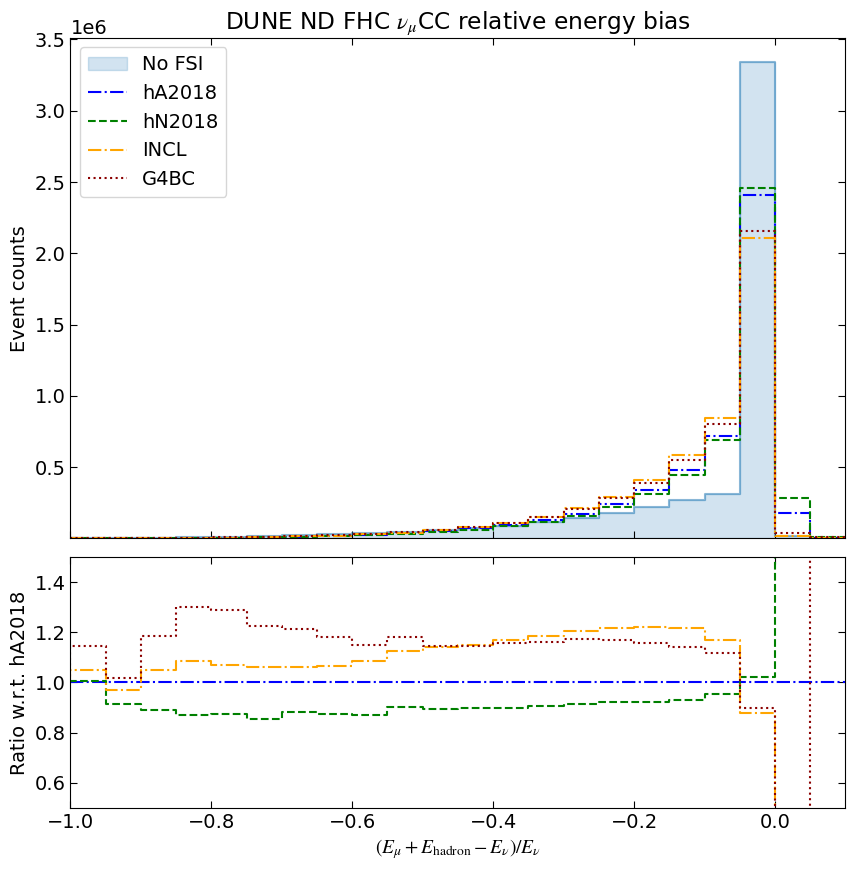

#events: 4466400 4560002 4572640 4543542 4477327


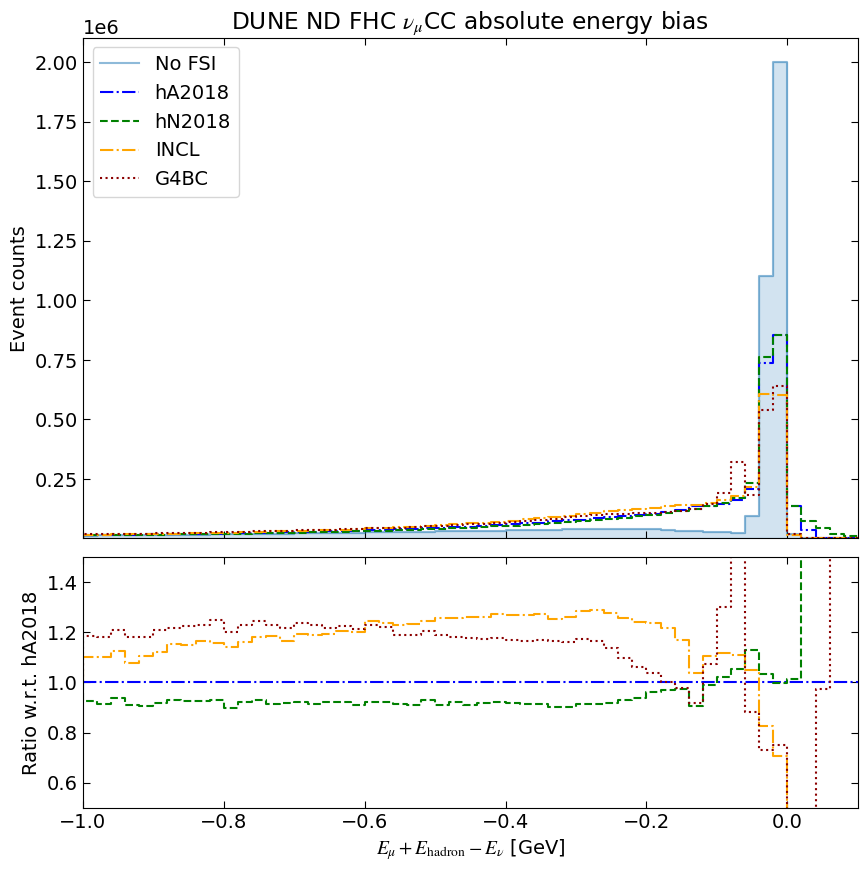

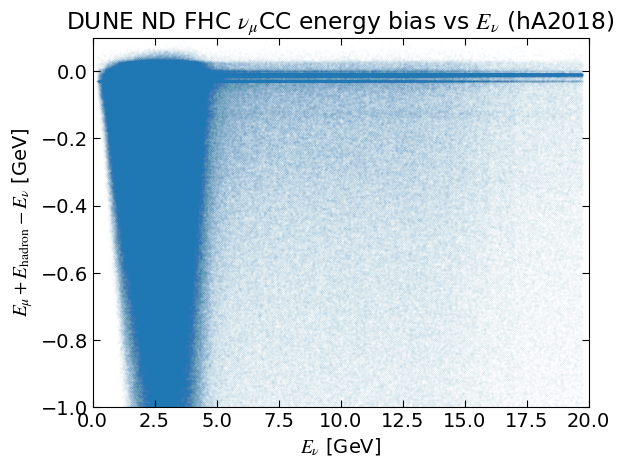

In [5]:
### relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_numu_hA18/vars_numu_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numu_hA18/vars_numu_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numu_hN18/vars_numu_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numu_INCL/vars_numu_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numu_G4BC/vars_numu_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, label="No FSI", step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\nu_\mu$CC relative energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([-1, 0.1])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$(E_\mu+E_{\rm hadron}-E_\nu)/E_\nu$")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([-1, 0.1])
axes[1].set_ylim([0.5, 1.5])
plt.savefig("FSIplots/relaEvbias_Ehadreco_FSI_numu.png")
plt.show()


### absolute energy bias
xlow, xupp = -1, 0.1
xx = np.linspace(xlow, xupp, 55+1)
yyi, _ = np.histogram(Ebiasi_numu_hA18, bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numu_hA18, bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numu_hN18, bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numu_INCL, bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numu_G4BC, bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("#events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\nu_\mu$CC absolute energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([xlow, xupp])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([xlow, xupp])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/absoEvbias_Ehad_FSI_numu.png")
plt.show()


### energy bias vs neutrino energy
plt.scatter(vars_numu_hA18["Ev"], Ebiasf_numu_hA18, alpha=0.1, s=0.01)
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
plt.xlim(0, 20)
plt.ylim(xlow, xupp)
plt.title(r"DUNE ND FHC $\nu_\mu$CC energy bias vs $E_\nu$ (hA2018)")
#plt.savefig("FSIplots/2DEvbias_Ehad_hA18_numu.png")
plt.show()


Check if all having the same #events: 9.999999999999998 10.0 10.0 10.0 10.0


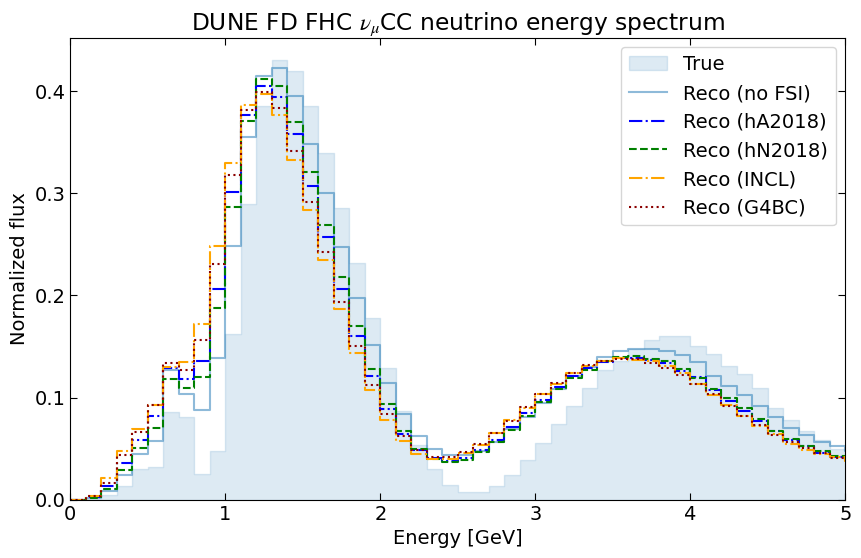

In [6]:
### oscillation plot
fluxND2FD_numu_1300 = FDosc_Flux_FHCnumu_1300*1e7/ND_Flux_FHCnumu
ND2FD_numu_wei_hA18 = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_hN18 = np.interp(vars_numu_hN18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_INCL = np.interp(vars_numu_INCL["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_G4BC = np.interp(vars_numu_G4BC["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
#plt.hist(vars_numu_hA18["Ev"], bins=100, alpha=0.3)
#plt.hist(vars_numu_hA18["Ev"], bins=100, alpha=0.3, weights=ND2FD_numu_wei_hA18)
#plt.show()

xx = np.arange(0, 20+0.1, 0.1)
yyt, _ = np.histogram(vars_numu_hA18["Ev"], bins=xx, weights=ND2FD_numu_wei_hA18, density=True); yyt = np.concatenate([[0],yyt])
yyi, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasi_numu_hA18, bins=xx, weights=ND2FD_numu_wei_hA18, density=True); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_hA18, density=True); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(vars_numu_hN18["Ev"]+Ebiasf_numu_hN18, bins=xx, weights=ND2FD_numu_wei_hN18, density=True); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_numu_INCL["Ev"]+Ebiasf_numu_INCL, bins=xx, weights=ND2FD_numu_wei_INCL, density=True); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_numu_G4BC["Ev"]+Ebiasf_numu_G4BC, bins=xx, weights=ND2FD_numu_wei_G4BC, density=True); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(xx, yyt, step="pre", label="True", alpha=0.15, color='tab:blue')
ax.step(xx, yyi, label="Reco (no FSI)", alpha=0.5, color='tab:blue')
ax.step(xx, yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Normalized flux")
ax.set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])
plt.savefig("FSIplots/FDoscNv_Ehadreco_FSI_numu.png")
plt.show()

Check if all having the same #events: 2559166.2587661087 10.0 2558385.081257793 2559153.931008408 2558047.4559883834


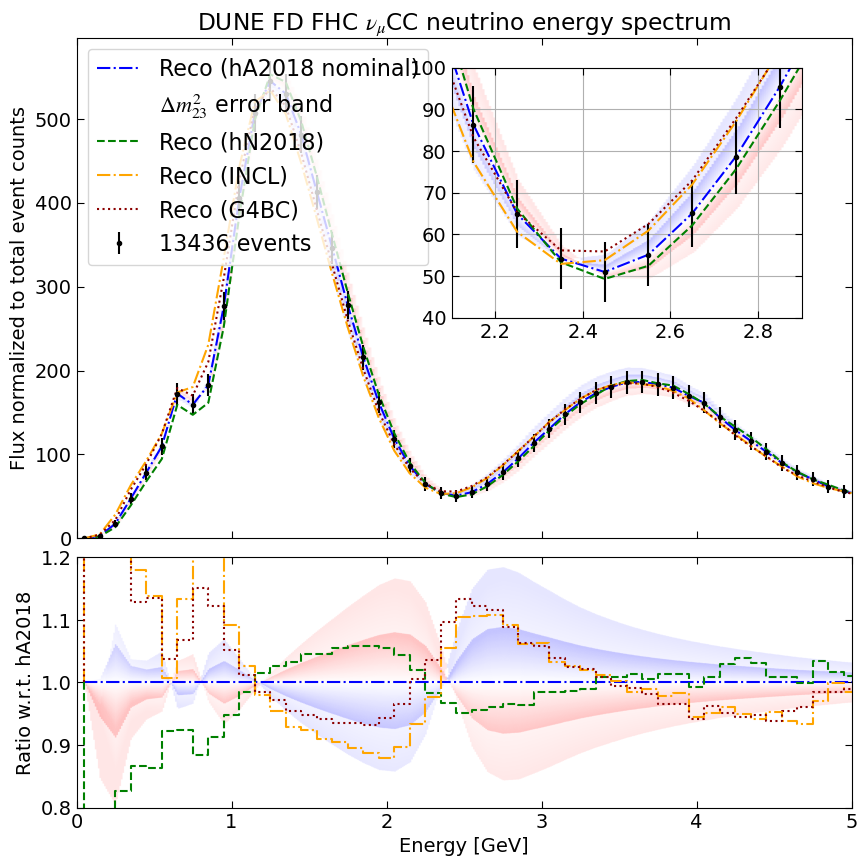

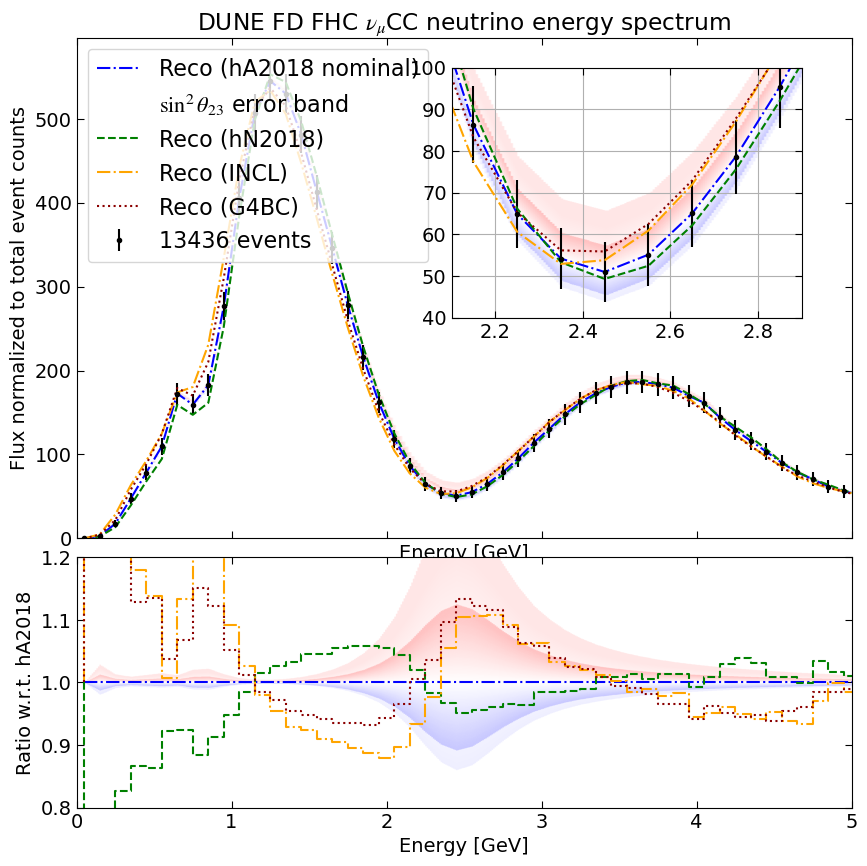

In [7]:
### oscillation sensitivity
fluxND2FD_numu_m23p = FDosc_Flux_FHCnumu_m23p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m23m = FDosc_Flux_FHCnumu_m23m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m232p = FDosc_Flux_FHCnumu_m232p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_m232m = FDosc_Flux_FHCnumu_m232m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t23p = FDosc_Flux_FHCnumu_t23p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t23m = FDosc_Flux_FHCnumu_t23m*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t232p = FDosc_Flux_FHCnumu_t232p*1e7/ND_Flux_FHCnumu
fluxND2FD_numu_t232m = FDosc_Flux_FHCnumu_t232m*1e7/ND_Flux_FHCnumu

ND2FD_numu_wei_1300 = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_1300)
ND2FD_numu_wei_m23p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m23p)
ND2FD_numu_wei_m23m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m23m)
ND2FD_numu_wei_m232p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m232p)
ND2FD_numu_wei_m232m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_m232m)
ND2FD_numu_wei_t23p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t23p)
ND2FD_numu_wei_t23m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t23m)
ND2FD_numu_wei_t232p = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t232p)
ND2FD_numu_wei_t232m = np.interp(vars_numu_hA18["Ev"], FDosc_Ev, fluxND2FD_numu_t232m)

xx = np.arange(0, 20+0.1, 0.1)
yyi, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasi_numu_hA18, bins=xx, weights=ND2FD_numu_wei_hA18, density=False)
yyf_hN18, _ = np.histogram(vars_numu_hN18["Ev"]+Ebiasf_numu_hN18, bins=xx, weights=ND2FD_numu_wei_hN18, density=False);
yyf_INCL, _ = np.histogram(vars_numu_INCL["Ev"]+Ebiasf_numu_INCL, bins=xx, weights=ND2FD_numu_wei_INCL, density=False);
yyf_G4BC, _ = np.histogram(vars_numu_G4BC["Ev"]+Ebiasf_numu_G4BC, bins=xx, weights=ND2FD_numu_wei_G4BC, density=False);
yyf_1300, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_1300, density=False); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_m23p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m23p, density=False); #yyf_m23p = np.concatenate([[0],yyf_m23p])
yyf_m23m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m23m, density=False); #yyf_m23m = np.concatenate([[0],yyf_m23m])
yyf_m232p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m232p, density=False); #yyf_m232p = np.concatenate([[0],yyf_m232p])
yyf_m232m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_m232m, density=False); #yyf_m232m = np.concatenate([[0],yyf_m232m])
yyf_t23p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t23p, density=False); #yyf_t23p = np.concatenate([[0],yyf_t23p])
yyf_t23m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t23m, density=False); #yyf_t23m = np.concatenate([[0],yyf_t23m])
yyf_t232p, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t232p, density=False); #yyf_t232p = np.concatenate([[0],yyf_t232p])
yyf_t232m, _ = np.histogram(vars_numu_hA18["Ev"]+Ebiasf_numu_hA18, bins=xx, weights=ND2FD_numu_wei_t232m, density=False); #yyf_t232m = np.concatenate([[0],yyf_t232m])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = int(7235 *624/336) # estimated total event counts
scale = Nv/np.sum(yyf_1300)
xx = (xx[1:]+xx[:-1])/2

### Δm^2_{23}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, label=r"$\Delta m^2_{23}$ error band", alpha=0, color='tab:blue')
#ax[0].fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, alpha=0.1, color='tab:blue')
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_m23p, scale*yyf_m23m, alpha=0.2, label=r"$\Delta m^2_{23}$ error band")
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_m232p, scale*yyf_m232m, alpha=0.1)
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
#ax[0].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.6, 0.35, 0.25])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
#ax_inset.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, alpha=0.1, color='tab:blue')
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_m23p, scale*yyf_m23m, alpha=0.2, resolution=4000)
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_m232p, scale*yyf_m232m, alpha=0.1, resolution=4000)
ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([40, 100])
ax_inset.set_xlim([2.1, 2.9])
ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_m23m, yyf_1300), safe_divide(yyf_m23p, yyf_1300), alpha=0.2, color='tab:blue')
#ax[1].fill_between(xx, safe_divide(yyf_m232m, yyf_1300), safe_divide(yyf_m232p, yyf_1300), alpha=0.1, color='tab:blue')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_m23p, yyf_1300), safe_divide(yyf_m23m, yyf_1300), alpha=0.2, resolution=2000)
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_m232p, yyf_1300), safe_divide(yyf_m232m, yyf_1300), alpha=0.1, resolution=2000)

ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadrec_FSI_numu_m23.png")
plt.show()


### sin^2 θ_{23}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0, color='tab:red')
#ax[0].fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_t23p, scale*yyf_t23m, alpha=0.2)
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_t232p, scale*yyf_t232m, alpha=0.1)
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.6, 0.35, 0.25])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
#ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_t23p, scale*yyf_t23m, alpha=0.2, resolution=4000)
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_t232p, scale*yyf_t232m, alpha=0.1, resolution=4000)
#ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([40, 100])
ax_inset.set_xlim([2.1, 2.9])
ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_t23m, yyf_1300), safe_divide(yyf_t23p, yyf_1300), alpha=0.2, color='tab:red')
#ax[1].fill_between(xx, safe_divide(yyf_t232m, yyf_1300), safe_divide(yyf_t232p, yyf_1300), alpha=0.1, color='tab:red')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_t23p, yyf_1300), safe_divide(yyf_t23m, yyf_1300), alpha=0.2, resolution=2000)
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_t232p, yyf_1300), safe_divide(yyf_t232m, yyf_1300), alpha=0.1, resolution=2000)
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadrec_FSI_numu_t23.png")
plt.show()
